#Perkenalan dan Objektif



---


NAMA: MITRA MARONA PUTRA GURUSINGA

BATCH HCK 006

Milestone 2

Phase 1


---



---

Sebuah perusahaan yang menerapkan sistem absensi per jamnya, menemukan kesulitan dengan kondisi di mana banyak karyawan mereka yang absen disaat yang dibutuhkan, baik dengan keterangan sakit yang resmi maupun tidak. Pada kasus ini saya sebagai analis diberi dataset yang berisi seluruh informasi karyawan dan data terkait jumlah absennya dalam jam. Sehingga, berdasarkan dataset ini saya berusaha melakukan model untuk memprediksi mengenai kemungkinan apakah karyawan akan absen lebih dari **kurang dari 3 jam (true positive)** atau lebih dari 3 jam berdasarkan karakteristik dan kondisi karyawan tersebut. Pada model ini, objektif utama saya adalah untuk menemukan model yang mampu memiliki tingkat akurasi yang tinggi, di mana berarti berusaha meminimalisir false positive dan false negative hasil prediksi model. Dengan model ini, diharapkan mampu membantu perusahaan dalam mengenali kemungkinan absen setiap karyawannya dan dapat mencegah kemungkinan adanya karyawan yang absen di saat terpenting perushaaan.



---




#Import dan Instalasi Pustaka

In [1]:
!pip install feature_engine

In [2]:
!pip install xgboost

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pickle
import xgboost

from sklearn.model_selection import train_test_split
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from scipy.stats import pointbiserialr, chi2_contingency, f_oneway, ttest_ind

import warnings
warnings.filterwarnings(action='ignore')

#Data Loading & Review

Pada section ini, saya melakukan penelusuran singkat terkait keseluruhan dataset saya

In [4]:
#membuat fungsi pengecekan outliers
def normal(df, col, fold):
    for i in col:
      upper = df[i].mean() + (fold * df[i].std())
      lower = df[i].mean() - (fold * df[i].std())

      outlier = df[(df[i] <= lower) | (df[i] >= upper)]

      print(f'{i}')
      print('percentage: ', len(outlier)/df.shape[0] * 100, '%')

def skew(df, col, fold):
    for i in col:
      Q1 = df[i].quantile(.25)
      Q3 = df[i].quantile(.75)

      IQR = Q3 - Q1

      upper = Q3 + (fold * IQR)
      lower = Q1 - (fold * IQR)

      outlier = df[(df[i] <= lower) | (df[i] >= upper)]

      print(f'{i}')
      print('percentage: ', len(outlier)/df.shape[0] * 100, '%')
      print('upper: ', upper)
      print('lower: ', lower)

In [5]:
#membuat variabel df berisi dataset awal
df = pd.read_excel('Absenteeism_at_work_Project.xls')

In [6]:
#melihat 10 data baris pertama
df.head(10)

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26.0,7.0,3,1,289.0,36.0,13.0,33.0,239554.0,...,0.0,1.0,2.0,1.0,0.0,1.0,90.0,172.0,30.0,4.0
1,36,0.0,7.0,3,1,118.0,13.0,18.0,50.0,239554.0,...,1.0,1.0,1.0,1.0,0.0,0.0,98.0,178.0,31.0,0.0
2,3,23.0,7.0,4,1,179.0,51.0,18.0,38.0,239554.0,...,0.0,1.0,0.0,1.0,0.0,0.0,89.0,170.0,31.0,2.0
3,7,7.0,7.0,5,1,279.0,5.0,14.0,39.0,239554.0,...,0.0,1.0,2.0,1.0,1.0,0.0,68.0,168.0,24.0,4.0
4,11,23.0,7.0,5,1,289.0,36.0,13.0,33.0,239554.0,...,0.0,1.0,2.0,1.0,0.0,1.0,90.0,172.0,30.0,2.0
5,3,23.0,7.0,6,1,179.0,51.0,18.0,38.0,239554.0,...,0.0,1.0,0.0,1.0,0.0,0.0,89.0,170.0,31.0,NaN
6,10,22.0,7.0,6,1,NaN,52.0,3.0,28.0,239554.0,...,0.0,1.0,1.0,1.0,0.0,4.0,80.0,172.0,27.0,8.0
7,20,23.0,7.0,6,1,260.0,50.0,11.0,36.0,239554.0,...,0.0,1.0,4.0,1.0,0.0,0.0,65.0,168.0,23.0,4.0
8,14,19.0,7.0,2,1,155.0,12.0,14.0,34.0,239554.0,...,0.0,1.0,2.0,1.0,0.0,0.0,95.0,196.0,25.0,40.0
9,1,22.0,7.0,2,1,235.0,11.0,14.0,37.0,239554.0,...,0.0,3.0,1.0,0.0,0.0,1.0,88.0,172.0,29.0,8.0


In [7]:
#melihat 10 data baris terakhir
df.tail(10)

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
730,6,22.0,7.0,3,1,189.0,29.0,13.0,33.0,264604.0,...,0.0,1.0,2.0,0.0,0.0,2.0,69.0,167.0,25.0,16.0
731,34,23.0,7.0,4,1,118.0,10.0,10.0,37.0,264604.0,...,0.0,1.0,0.0,0.0,0.0,0.0,83.0,172.0,28.0,2.0
732,10,22.0,7.0,4,1,361.0,52.0,3.0,28.0,264604.0,...,0.0,1.0,1.0,1.0,0.0,4.0,80.0,172.0,27.0,8.0
733,28,22.0,7.0,4,1,225.0,26.0,9.0,28.0,264604.0,...,0.0,1.0,1.0,0.0,0.0,2.0,69.0,169.0,24.0,8.0
734,13,13.0,7.0,2,1,369.0,17.0,12.0,31.0,264604.0,...,0.0,1.0,3.0,1.0,0.0,0.0,70.0,169.0,25.0,80.0
735,11,14.0,7.0,3,1,289.0,36.0,13.0,33.0,264604.0,...,0.0,1.0,2.0,1.0,0.0,1.0,90.0,172.0,30.0,8.0
736,1,11.0,7.0,3,1,235.0,11.0,14.0,37.0,264604.0,...,0.0,3.0,1.0,0.0,0.0,1.0,88.0,172.0,29.0,4.0
737,4,0.0,0.0,3,1,118.0,14.0,13.0,40.0,271219.0,...,0.0,1.0,1.0,1.0,0.0,8.0,98.0,170.0,34.0,0.0
738,8,0.0,0.0,4,2,231.0,35.0,14.0,39.0,271219.0,...,0.0,1.0,2.0,1.0,0.0,2.0,100.0,170.0,35.0,0.0
739,35,0.0,0.0,6,3,179.0,45.0,14.0,53.0,271219.0,...,0.0,1.0,1.0,0.0,0.0,1.0,77.0,175.0,25.0,0.0


In [8]:
#menambahkan _ sebagai pemisah kata di nama kolom
df.columns = df.columns.str.replace(" ", "_")

In [9]:
#memeriksa nilai unik setiap kolom
df.nunique()

ID                                 36
Reason_for_absence                 28
Month_of_absence                   13
Day_of_the_week                     5
Seasons                             4
Transportation_expense             24
Distance_from_Residence_to_Work    25
Service_time                       18
Age                                22
Work_load_Average/day_             38
Hit_target                         13
Disciplinary_failure                2
Education                           4
Son                                 5
Social_drinker                      2
Social_smoker                       2
Pet                                 6
Weight                             26
Height                             14
Body_mass_index                    17
Absenteeism_time_in_hours          19
dtype: int64

In [10]:
#melihat nilai unik dalam kolom Education
df['Education'].unique()

array([ 1.,  3.,  2., nan,  4.])

In [11]:
#melihat missing values
df.isna().sum()

ID                                  0
Reason_for_absence                  3
Month_of_absence                    1
Day_of_the_week                     0
Seasons                             0
Transportation_expense              7
Distance_from_Residence_to_Work     3
Service_time                        3
Age                                 3
Work_load_Average/day_             10
Hit_target                          6
Disciplinary_failure                6
Education                          10
Son                                 6
Social_drinker                      3
Social_smoker                       4
Pet                                 2
Weight                              1
Height                             14
Body_mass_index                    31
Absenteeism_time_in_hours          22
dtype: int64

#Exploratory Data Analysis (EDA)

Pada section ini, saya melakukan analisa untuk mendapatkan beberapa konteks dan informasi dari dataset saya.

In [12]:
#membuat dataframe baru untuk kebutuhan EDA
df_eda = df.copy()

In [13]:
#melihat nama-nama kolom
df_eda.columns

Index(['ID', 'Reason_for_absence', 'Month_of_absence', 'Day_of_the_week',
       'Seasons', 'Transportation_expense', 'Distance_from_Residence_to_Work',
       'Service_time', 'Age', 'Work_load_Average/day_', 'Hit_target',
       'Disciplinary_failure', 'Education', 'Son', 'Social_drinker',
       'Social_smoker', 'Pet', 'Weight', 'Height', 'Body_mass_index',
       'Absenteeism_time_in_hours'],
      dtype='object')

In [14]:
#membuat variabel berisi list kolom numerik dan kategorik
num_col = ['Month_of_absence', 'Transportation_expense', 'Distance_from_Residence_to_Work', 'Service_time', 'Age', 'Work_load_Average/day_', 'Hit_target', 'Weight', 'Height', 'Body_mass_index']
cat_col = ['Reason_for_absence','Day_of_the_week', 'Seasons', 'Disciplinary_failure', 'Education', 'Son', 'Social_drinker', 'Social_smoker', 'Pet']


In [15]:
#melihat nilai unik di kolom Reason_for_absence
df_eda.Reason_for_absence.unique()

array([26.,  0., 23.,  7., 22., 19.,  1., 11., 14., 21., 10., 13., 28.,
       18., 25., 24.,  6., 27., 17.,  8., 12.,  5.,  9., 15.,  4.,  3.,
       nan,  2., 16.])

##Cardinality

In [16]:
#melakukan handling category target
df_eda.Absenteeism_time_in_hours.value_counts().sort_index()

0.0       36
1.0       88
2.0      155
3.0      110
4.0       60
5.0        7
7.0        1
8.0      199
16.0      19
24.0      16
32.0       5
40.0       7
48.0       1
56.0       2
64.0       3
80.0       3
104.0      1
112.0      2
120.0      3
Name: Absenteeism_time_in_hours, dtype: int64

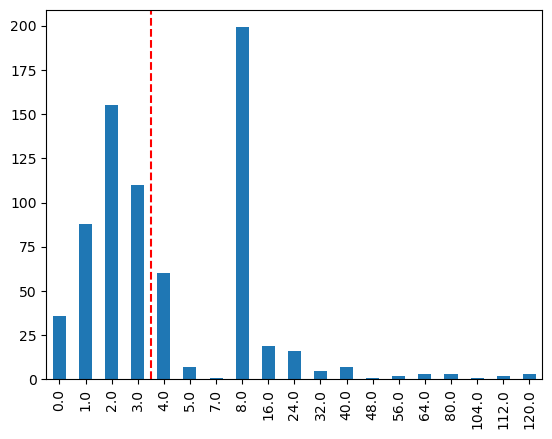

In [17]:
#melakukan plot bar dan memberi tanda di mana data target akan dibagi 2
df_eda.Absenteeism_time_in_hours.value_counts().sort_index().plot(kind='bar').axvline(x=3.5, color='red', linestyle='--', label='x = 3.5')
plt.show()


In [18]:
#melihat jumlah kemunculan unik value setiap kolom kategorikal
for i in cat_col:
  print(i)
  print(df_eda[i].value_counts().sort_index())
  print('-'*30)

Reason_for_absence
0.0      43
1.0      16
2.0       1
3.0       1
4.0       2
5.0       3
6.0       8
7.0      15
8.0       6
9.0       4
10.0     25
11.0     26
12.0      8
13.0     55
14.0     19
15.0      2
16.0      3
17.0      1
18.0     21
19.0     40
21.0      6
22.0     37
23.0    149
24.0      3
25.0     31
26.0     33
27.0     69
28.0    110
Name: Reason_for_absence, dtype: int64
------------------------------
Day_of_the_week
2    161
3    154
4    156
5    125
6    144
Name: Day_of_the_week, dtype: int64
------------------------------
Seasons
1    170
2    192
3    183
4    195
Name: Seasons, dtype: int64
------------------------------
Disciplinary_failure
0.0    695
1.0     39
Name: Disciplinary_failure, dtype: int64
------------------------------
Education
1.0    601
2.0     46
3.0     79
4.0      4
Name: Education, dtype: int64
------------------------------
Son
0.0    295
1.0    228
2.0    155
3.0     15
4.0     41
Name: Son, dtype: int64
------------------------------


In [19]:
#melakukan handling cardinality
df_eda.loc[df_eda['Reason_for_absence'] <=21 , 'Reason_for_absence'] = 0
df_eda.loc[df_eda['Reason_for_absence'] > 21 , 'Reason_for_absence'] = 1
df_eda.loc[df_eda['Education'] == 4.0, 'Education'] = 3.0
df_eda.loc[df_eda['Son']== 4.0, 'Son'] = 3.0
df_eda.loc[df_eda['Pet'] > 2, 'Pet'] = 3.0


In [20]:
#melihat jumlah kemunculan unik value setiap kolom kategorikal
for i in cat_col:
  print(i)
  print(df_eda[i].value_counts().sort_index())
  print('-'*30)

Reason_for_absence
0.0    305
1.0    432
Name: Reason_for_absence, dtype: int64
------------------------------
Day_of_the_week
2    161
3    154
4    156
5    125
6    144
Name: Day_of_the_week, dtype: int64
------------------------------
Seasons
1    170
2    192
3    183
4    195
Name: Seasons, dtype: int64
------------------------------
Disciplinary_failure
0.0    695
1.0     39
Name: Disciplinary_failure, dtype: int64
------------------------------
Education
1.0    601
2.0     46
3.0     83
Name: Education, dtype: int64
------------------------------
Son
0.0    295
1.0    228
2.0    155
3.0     56
Name: Son, dtype: int64
------------------------------
Social_drinker
0.0    319
1.0    418
Name: Social_drinker, dtype: int64
------------------------------
Social_smoker
0.0    682
1.0     54
Name: Social_smoker, dtype: int64
------------------------------
Pet
0.0    459
1.0    137
2.0     96
3.0     46
Name: Pet, dtype: int64
------------------------------


Berdasarkan penelusuran terhadap data yang merepresentasikan nilai kategori, ditemukan bahwa masih ada cardinality yang tidak seimbang dalam beberapa kolom. Sehingga saya akan melakukan sedikit handling cardinality.



---


**Informasi dari sumber dataset**

Reason for absence (ICD).

Absensi yang dibuktikan oleh International Code of Diseases (ICD) dikelompokkan menjadi 21 kategori (I hingga XXI) sebagai berikut:

* I Penyakit infeksi dan parasit tertentu
* II Neoplasma
* III Penyakit darah dan organ pembentuk darah serta gangguan tertentu yang melibatkan mekanisme kekebalan tubuh
* IV Penyakit endokrin, gizi dan metabolik
* V Gangguan mental dan perilaku
* VI Penyakit pada sistem saraf
* VII Penyakit mata dan adneksa
* VIII Penyakit telinga dan proses mastoid
* IX Penyakit pada sistem peredaran darah
* X Penyakit pada sistem pernapasan
* XI Penyakit pada sistem pencernaan
* XII Penyakit kulit dan jaringan subkutan
* XIII Penyakit pada sistem muskuloskeletal dan jaringan ikat
* XIV Penyakit pada sistem genitourinari
* XV Kehamilan, persalinan dan masa nifas
* XVI Kondisi tertentu yang berasal dari periode perinatal
* XVII Malformasi kongenital, deformasi dan kelainan kromosom
* XVIII Gejala, tanda dan temuan klinis dan laboratorium abnormal, tidak diklasifikasikan di tempat lain
* XIX Cedera, keracunan dan konsekuensi lain dari penyebab eksternal
* XX Penyebab eksternal morbiditas dan mortalitas
* XXI Faktor-faktor yang mempengaruhi status kesehatan dan kontak dengan pelayanan kesehatan.

Dan 7 kategori tanpa (ICD) pasien tindak lanjut (22), konsultasi medis (23), donor darah (24), pemeriksaan laboratorium (25), ketidakhadiran yang tidak wajar (26), fisioterapi (27), konsultasi gigi (28).


---



Berdasarkan keterangan dari sumber dataset di atas, kolom Reason_for_absence terbagi atas 2 kategori yang dibedakan berdasarkan izin dengan International Code of Diseases (ICD), dan yang tidak ada ICD. Sehingga, atas pengetahuan tersebut saya akan membagi nilai unik di kolom ini hanya menjadi 2 dengan label 0 dan 1.

Secara umum hal-hal yang telah berubah dari dataset yang melalui section ini adalah pada kolom-kolom sebagai berikut:

* Kolom Reason_for_absence yang dimodifikasi sekaligus handling cardinality-nya menjadi 2 kategori berdasarkan informasi sumber dataset mengenai pembagian 2 kategori yang dibedakan dari perizinan dengan ICD dan non ICD
* Kolom Education yang di-handle cardinality dengan menggabungkan nilai 4 ke kategori nilai 3
* Kolom Son yang di-handle cardinality dengan menggabungkan nilai 4 ke kategori nilai 3
* Kolom Pet yang di-handle cardinality dengan menggabungkan nilai lebih dari 2 ke kategori nilai 3

#Feature Engineering

Pada section ini, saya melakukan eksplorasi yang berfokus untuk melakukan treatment pada dataset numerikal dan kategorikal sebelum dilakukan feature selection, preprocesing, modelling.

In [21]:
#menghapus kolom yang tidak diperlukan
df_fe = df_eda.drop('ID', axis=1)

In [22]:
#melihat nilai median kolom target
df_fe["Absenteeism_time_in_hours"].median()

3.0

In [23]:
#membuat kolom baru hasil dari modifikasi target
df_fe['Absenteeism_cat'] = np.where(df_fe["Absenteeism_time_in_hours"] > df_fe["Absenteeism_time_in_hours"].median(), 1, 0)

In [24]:
#melihat jumlah nilai unik pada kolom baru hasil modifikasi target
df_fe.Absenteeism_cat.value_counts()

0    411
1    329
Name: Absenteeism_cat, dtype: int64

Text(0.5, 1.0, 'Jumlah Kemunculan Setiap Kategori Absenteeism_cat')

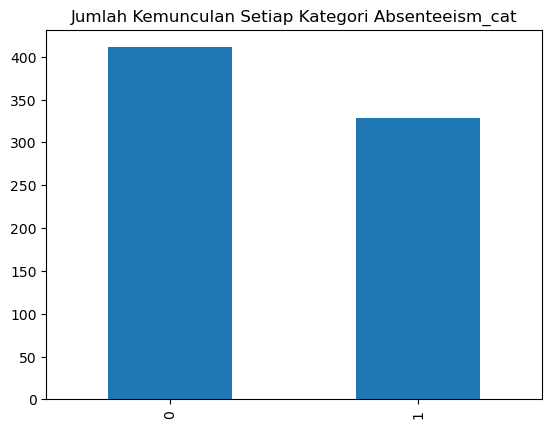

In [25]:
#melakukan plot bar kolom baru target
df_fe.Absenteeism_cat.value_counts().plot(kind='bar')
plt.title('Jumlah Kemunculan Setiap Kategori Absenteeism_cat')

In [26]:
#melihat perbandingan keseimbangan nilai unik di kolom target
df_fe.Absenteeism_cat.sum()/len(df_fe.Absenteeism_cat)

0.4445945945945946

In [27]:
#menghapus kolom yang tidak digunakan lagi
df_fe.drop('Absenteeism_time_in_hours', axis=1, inplace=True)

Berdasarkan handling target tersebut, saya membuat kategori baru yaitu 0 dan 1. Di mana kategori nilai 1 ketika nilai dalam kolom "Absenteeism_time_in_hours" lebih besar dari median (3), dan nilai 0 jika kurang dari atau sama dengan median. Berdasarkan hasil plot dan perhitungan, terlihat bahwa target masih dapat dikatakan **balance**

##Get Data for Inference

Pada section ini, saya mengambil sampel random dari dataset sebelum dilakukan splitting menjadi dataset train dan test

In [28]:
#menyimpan 10 data random dari data asli untuk digunakan sebagai data inference ke dalam variabel data_inf
data_inf = df_fe.sample(10, random_state=1)

In [29]:
#melihat indeks dataset inference
data_inf.index

Int64Index([681, 257, 527, 637, 429, 350, 412, 189, 670, 411], dtype='int64')

In [30]:
data_inf

,Reason_for_absence,Month_of_absence,Day_of_the_week,Seasons,Transportation_expense,Distance_from_Residence_to_Work,Service_time,Age,Work_load_Average/day_,Hit_target,Disciplinary_failure,Education,Son,Social_drinker,Social_smoker,Pet,Weight,Height,Body_mass_index,Absenteeism_cat
681,0.0,5.0,5,3,225.0,15.0,15.0,41.0,237656.0,99.0,0.0,3.0,2.0,1.0,0.0,2.0,94.0,182.0,28.0,1
257,0.0,8.0,5,1,300.0,26.0,13.0,43.0,265615.0,94.0,0.0,1.0,2.0,1.0,1.0,1.0,77.0,175.0,25.0,0
527,1.0,10.0,2,4,189.0,29.0,13.0,33.0,284853.0,91.0,0.0,1.0,2.0,0.0,0.0,2.0,69.0,167.0,25.0,1
637,0.0,3.0,2,2,225.0,26.0,9.0,28.0,222196.0,99.0,0.0,1.0,1.0,0.0,0.0,2.0,69.0,169.0,24.0,1
429,1.0,5.0,4,3,179.0,51.0,18.0,38.0,246074.0,99.0,0.0,1.0,0.0,1.0,0.0,0.0,89.0,170.0,31.0,1
350,1.0,12.0,5,4,235.0,11.0,14.0,37.0,236629.0,93.0,0.0,3.0,NaN,0.0,0.0,1.0,88.0,172.0,29.0,0
412,1.0,4.0,4,3,179.0,51.0,18.0,38.0,239409.0,98.0,0.0,1.0,0.0,1.0,0.0,0.0,89.0,170.0,31.0,1
189,1.0,4.0,6,3,225.0,26.0,9.0,28.0,326452.0,96.0,0.0,1.0,1.0,0.0,0.0,2.0,69.0,169.0,24.0,0
670,1.0,4.0,3,3,155.0,12.0,14.0,34.0,246288.0,91.0,0.0,1.0,2.0,1.0,0.0,0.0,95.0,196.0,25.0,1
411,1.0,3.0,3,3,246.0,25.0,16.0,41.0,244387.0,98.0,0.0,1.0,0.0,1.0,0.0,0.0,67.0,170.0,23.0,0


In [31]:
#menghapus data inference dari df_eda
df_fe.drop(data_inf.index, inplace=True)

In [32]:
#melakukan reset index untuk data inference dan df_eda
df_fe.reset_index(drop=True, inplace=True)
data_inf.reset_index(drop=True, inplace=True)

In [33]:
#print shape setiap dataframe
print(f'df_fe shape: {df_fe.shape}')
print(f'data_inf shape: {data_inf.shape}')

df_fe shape: (730, 20)
data_inf shape: (10, 20)


##Split Dataset

Setelah mendapatkan dataset yang sudah dilakukan proses EDA dan pengambilan data untuk inference, maka diperoleh dataset yang akan dilakukan untuk persiapan feature selection. Maka di tahap ini, saya membagi datatset menjadi train dan test

In [34]:
#melakukan split dataset train dan test
X = df_fe.drop('Absenteeism_cat', axis=1)
y = df_fe['Absenteeism_cat']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f'df_fe: {df_fe.shape}')
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')


df_fe: (730, 20)
X shape: (730, 19)
y shape: (730,)
X_train shape: (511, 19)
y_train shape: (511,)
X_test shape: (219, 19)
y_test shape: (219,)


In [35]:
X_train

,Reason_for_absence,Month_of_absence,Day_of_the_week,Seasons,Transportation_expense,Distance_from_Residence_to_Work,Service_time,Age,Work_load_Average/day_,Hit_target,Disciplinary_failure,Education,Son,Social_drinker,Social_smoker,Pet,Weight,Height,Body_mass_index
683,0.0,5.0,2,3,235.0,16.0,8.0,32.0,237656.0,99.0,0.0,3.0,0.0,0.0,0.0,0.0,75.0,178.0,25.0
645,1.0,3.0,4,3,369.0,17.0,12.0,31.0,222196.0,99.0,0.0,1.0,3.0,1.0,0.0,0.0,70.0,169.0,25.0
163,0.0,3.0,6,2,260.0,50.0,11.0,36.0,343253.0,95.0,0.0,1.0,3.0,1.0,0.0,0.0,65.0,168.0,23.0
360,1.0,1.0,2,2,289.0,36.0,13.0,33.0,330061.0,100.0,0.0,1.0,2.0,1.0,0.0,1.0,90.0,172.0,30.0
640,0.0,3.0,4,3,155.0,12.0,14.0,34.0,222196.0,99.0,0.0,1.0,2.0,1.0,0.0,0.0,95.0,196.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,1.0,10.0,5,4,291.0,31.0,12.0,40.0,253465.0,93.0,0.0,1.0,1.0,1.0,0.0,1.0,73.0,171.0,25.0
106,1.0,12.0,5,4,225.0,26.0,NaN,28.0,261306.0,97.0,0.0,1.0,1.0,0.0,0.0,2.0,69.0,169.0,NaN
270,0.0,9.0,4,1,289.0,36.0,13.0,33.0,294217.0,81.0,0.0,1.0,2.0,1.0,NaN,1.0,90.0,NaN,NaN
435,1.0,6.0,2,3,118.0,10.0,10.0,37.0,253957.0,95.0,0.0,1.0,0.0,0.0,0.0,0.0,83.0,172.0,28.0


In [36]:
#melihat unik value setiap kolom df_fe, X_train dan X_test
for i in [df_fe, X_train, X_test]:

    print(i.nunique())
    print('-' * 30)

Reason_for_absence                  2
Month_of_absence                   13
Day_of_the_week                     5
Seasons                             4
Transportation_expense             24
Distance_from_Residence_to_Work    25
Service_time                       18
Age                                22
Work_load_Average/day_             38
Hit_target                         13
Disciplinary_failure                2
Education                           3
Son                                 4
Social_drinker                      2
Social_smoker                       2
Pet                                 4
Weight                             26
Height                             14
Body_mass_index                    17
Absenteeism_cat                     2
dtype: int64
------------------------------
Reason_for_absence                  2
Month_of_absence                   13
Day_of_the_week                     5
Seasons                             4
Transportation_expense             24
Distan

##Numerical Feature

Pada section ini, fokus pengerjaan adalah pada pengolahan dataset hasil eksplorasi sebelumnya yang termasuk tipe numerikal

In [37]:
#melihat dataset kolom numerikal
df_fe[num_col]

,Month_of_absence,Transportation_expense,Distance_from_Residence_to_Work,Service_time,Age,Work_load_Average/day_,Hit_target,Weight,Height,Body_mass_index
0,7.0,289.0,36.0,13.0,33.0,239554.0,97.0,90.0,172.0,30.0
1,7.0,118.0,13.0,18.0,50.0,239554.0,97.0,98.0,178.0,31.0
2,7.0,179.0,51.0,18.0,38.0,239554.0,97.0,89.0,170.0,31.0
3,7.0,279.0,5.0,14.0,39.0,239554.0,97.0,68.0,168.0,24.0
4,7.0,289.0,36.0,13.0,33.0,239554.0,97.0,90.0,172.0,30.0
...,...,...,...,...,...,...,...,...,...,...
725,7.0,289.0,36.0,13.0,33.0,264604.0,93.0,90.0,172.0,30.0
726,7.0,235.0,11.0,14.0,37.0,264604.0,93.0,88.0,172.0,29.0
727,0.0,118.0,14.0,13.0,40.0,271219.0,95.0,98.0,170.0,34.0
728,0.0,231.0,35.0,14.0,39.0,271219.0,95.0,100.0,170.0,35.0


In [38]:
#memeriksa central tendency dataframe df_fe
df_fe[num_col].describe().T

,count,mean,std,min,25%,50%,75%,max
Month_of_absence,729.0,6.326475,3.441485,0.0,3.00,6.0,9.0,12.0
Transportation_expense,723.0,221.107884,67.251436,118.0,179.00,225.0,260.0,388.0
Distance_from_Residence_to_Work,727.0,29.701513,14.864597,5.0,16.00,26.0,50.0,52.0
Service_time,727.0,12.547455,4.403247,1.0,9.00,13.0,16.0,29.0
Age,727.0,36.453920,6.498167,27.0,31.00,37.0,40.0,58.0
Work_load_Average/day_,720.0,271414.318056,39056.542488,205917.0,244387.00,264249.0,284853.0,378884.0
Hit_target,724.0,94.570442,3.798414,81.0,92.75,95.0,97.0,100.0
Weight,729.0,79.042524,12.892502,56.0,69.00,83.0,89.0,108.0
Height,716.0,172.127095,6.038968,163.0,169.00,170.0,172.0,196.0
Body_mass_index,699.0,26.686695,4.310045,19.0,24.00,25.0,31.0,38.0


###Missing Values

In [39]:
#melihat missing values di kolom numerikal
df_fe[num_col].isna().sum()

Month_of_absence                    1
Transportation_expense              7
Distance_from_Residence_to_Work     3
Service_time                        3
Age                                 3
Work_load_Average/day_             10
Hit_target                          6
Weight                              1
Height                             14
Body_mass_index                    31
dtype: int64

In [40]:
#melakukan imputasi missing values
imp_num = SimpleImputer(strategy='median')

df_fe[num_col] = imp_num.fit_transform(df_fe[num_col])
df_fe[num_col].isna().sum()

Month_of_absence                   0
Transportation_expense             0
Distance_from_Residence_to_Work    0
Service_time                       0
Age                                0
Work_load_Average/day_             0
Hit_target                         0
Weight                             0
Height                             0
Body_mass_index                    0
dtype: int64

###Outliers

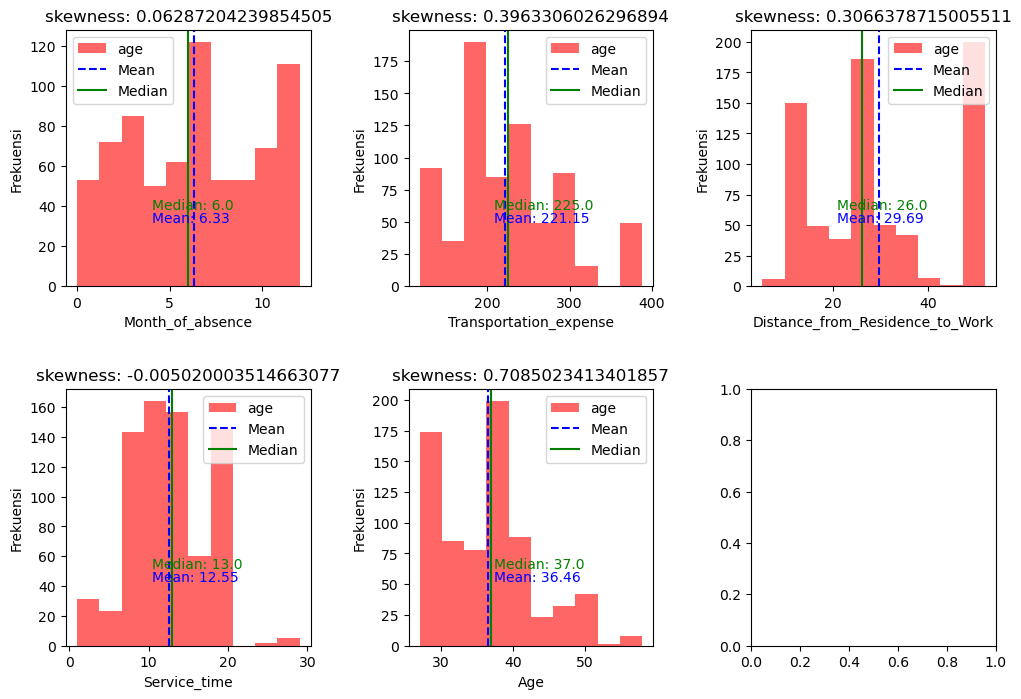

In [41]:
#plot histogram kolom-kolom numerikal
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

for i, j in enumerate(['Month_of_absence', 'Transportation_expense', 'Distance_from_Residence_to_Work', 'Service_time', 'Age']):
    a = df_fe[f'{j}']
    row = i // 3
    col = i % 3

    ax[row, col].hist(a, bins=10, alpha=0.6, color='red', label='age')
    ax[row, col].set_xlabel(f'{j}')
    ax[row, col].set_ylabel('Frekuensi')
    ax[row, col].set_title(f'skewness: {a.skew()}')
    ax[row, col].text(0.35, 0.25, f'Mean: {a.mean():.2f}', color='blue', transform=ax[row, col].transAxes)
    ax[row, col].text(0.35, 0.3, f'Median: {a.median()}', color='green', transform=ax[row, col].transAxes)
    ax[row, col].axvline(a.mean(), color='blue', linestyle='--', linewidth=1.5, label='Mean')
    ax[row, col].axvline(a.median(), color='green', linestyle='-', linewidth=1.5, label='Median')
    ax[row, col].legend()

plt.subplots_adjust(wspace=0.4, hspace=0.4)

plt.show()

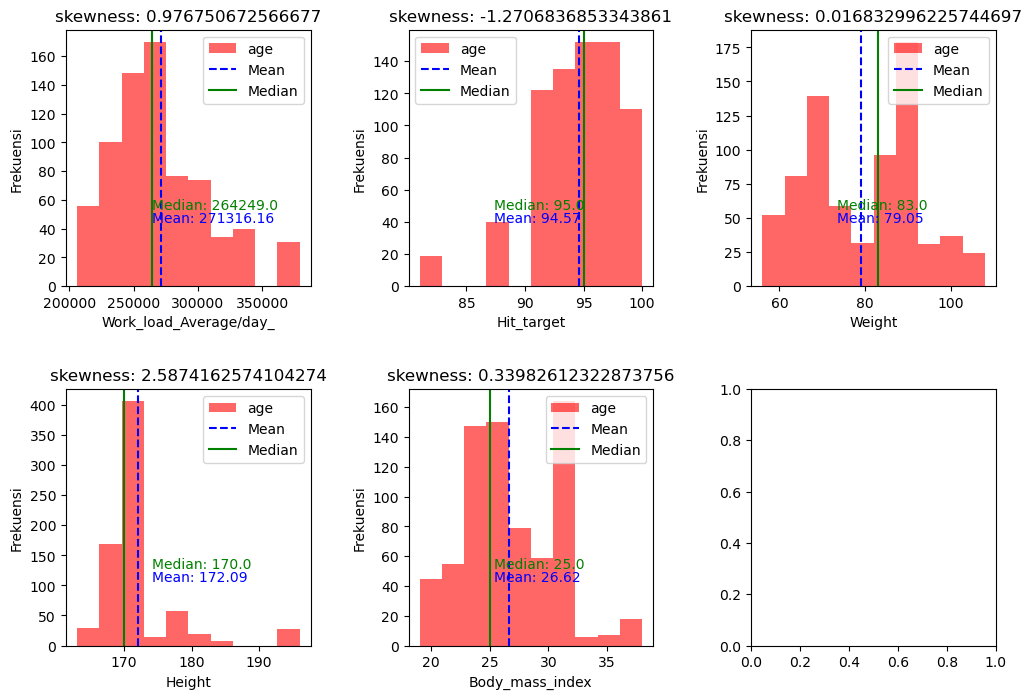

In [42]:
#plot histogram kolom-kolom numerikal
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

for i, j in enumerate(['Work_load_Average/day_', 'Hit_target', 'Weight', 'Height', 'Body_mass_index']):
    a = df_fe[f'{j}']
    row = i // 3
    col = i % 3

    ax[row, col].hist(a, bins=10, alpha=0.6, color='red', label='age')
    ax[row, col].set_xlabel(f'{j}')
    ax[row, col].set_ylabel('Frekuensi')
    ax[row, col].set_title(f'skewness: {a.skew()}')
    ax[row, col].text(0.35, 0.25, f'Mean: {a.mean():.2f}', color='blue', transform=ax[row, col].transAxes)
    ax[row, col].text(0.35, 0.3, f'Median: {a.median()}', color='green', transform=ax[row, col].transAxes)
    ax[row, col].axvline(a.mean(), color='blue', linestyle='--', linewidth=1.5, label='Mean')
    ax[row, col].axvline(a.median(), color='green', linestyle='-', linewidth=1.5, label='Median')
    ax[row, col].legend()

plt.subplots_adjust(wspace=0.4, hspace=0.4)

plt.show()

In [43]:
#membuat variabel berisi list nama kolom numerik distribusi normal dan skew
gauss = ['Month_of_absence', 'Distance_from_Residence_to_Work', 'Transportation_expense', 'Service_time', 'Weight', 'Body_mass_index']
iqr = ['Age', 'Work_load_Average/day_', 'Hit_target', 'Height']

In [44]:
df_fe

,Reason_for_absence,Month_of_absence,Day_of_the_week,Seasons,Transportation_expense,Distance_from_Residence_to_Work,Service_time,Age,Work_load_Average/day_,Hit_target,Disciplinary_failure,Education,Son,Social_drinker,Social_smoker,Pet,Weight,Height,Body_mass_index,Absenteeism_cat
0,1.0,7.0,3,1,289.0,36.0,13.0,33.0,239554.0,97.0,0.0,1.0,2.0,1.0,0.0,1.0,90.0,172.0,30.0,1
1,0.0,7.0,3,1,118.0,13.0,18.0,50.0,239554.0,97.0,1.0,1.0,1.0,1.0,0.0,0.0,98.0,178.0,31.0,0
2,1.0,7.0,4,1,179.0,51.0,18.0,38.0,239554.0,97.0,0.0,1.0,0.0,1.0,0.0,0.0,89.0,170.0,31.0,0
3,0.0,7.0,5,1,279.0,5.0,14.0,39.0,239554.0,97.0,0.0,1.0,2.0,1.0,1.0,0.0,68.0,168.0,24.0,1
4,1.0,7.0,5,1,289.0,36.0,13.0,33.0,239554.0,97.0,0.0,1.0,2.0,1.0,0.0,1.0,90.0,172.0,30.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,0.0,7.0,3,1,289.0,36.0,13.0,33.0,264604.0,93.0,0.0,1.0,2.0,1.0,0.0,1.0,90.0,172.0,30.0,1
726,0.0,7.0,3,1,235.0,11.0,14.0,37.0,264604.0,93.0,0.0,3.0,1.0,0.0,0.0,1.0,88.0,172.0,29.0,1
727,0.0,0.0,3,1,118.0,14.0,13.0,40.0,271219.0,95.0,0.0,1.0,1.0,1.0,0.0,3.0,98.0,170.0,34.0,0
728,0.0,0.0,4,2,231.0,35.0,14.0,39.0,271219.0,95.0,0.0,1.0,2.0,1.0,0.0,2.0,100.0,170.0,35.0,0


In [45]:
#menggunakan fungsi pemeriksaan outliers distribusi normal
normal(df_fe, gauss, 3)

Month_of_absence
percentage:  0.0 %
Distance_from_Residence_to_Work
percentage:  0.0 %
Transportation_expense
percentage:  0.0 %
Service_time
percentage:  0.684931506849315 %
Weight
percentage:  0.0 %
Body_mass_index
percentage:  0.0 %


In [46]:
#menggunakan fungsi pemeriksaan outliers distribusi skew
skew(df_fe, iqr, 1.5)

Age
percentage:  1.095890410958904 %
upper:  53.5
lower:  17.5
Work_load_Average/day_
percentage:  4.2465753424657535 %
upper:  345552.0
lower:  183688.0
Hit_target
percentage:  4.2465753424657535 %
upper:  103.0
lower:  87.0
Height
percentage:  16.027397260273972 %
upper:  176.5
lower:  164.5


In [47]:
#melakukan capping outliers untuk kolom numerik terpilih (normal dist.)
wins_gauss = Winsorizer(capping_method='gaussian', tail='both', fold=3, variables=gauss)

df_fe[gauss] = wins_gauss.fit_transform(df_fe[gauss])

In [48]:
#melakukan capping outliers untuk kolom numerik terpilih (skew dist.)
wins_iqr = Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=iqr)

df_fe[iqr] = wins_iqr.fit_transform(df_fe[iqr])

In [49]:
#melihat central tendency data sebelum handle outliers
print(df_eda.describe())
print('-'*60)
print(df_fe.describe())

               ID  Reason_for_absence  Month_of_absence  Day_of_the_week  \
count  740.000000          737.000000        739.000000       740.000000   
mean    18.017568            0.586160          6.319350         3.914865   
std     11.021247            0.492855          3.435948         1.421675   
min      1.000000            0.000000          0.000000         2.000000   
25%      9.000000            0.000000          3.000000         3.000000   
50%     18.000000            1.000000          6.000000         4.000000   
75%     28.000000            1.000000          9.000000         5.000000   
max     36.000000            1.000000         12.000000         6.000000   

          Seasons  Transportation_expense  Distance_from_Residence_to_Work  \
count  740.000000              733.000000                       737.000000   
mean     2.544595              221.035471                        29.667571   
std      1.111831               66.954179                        14.848124   
min

###Scalling

In [50]:
#melakukan scalling pada kolom numerik gauss dengan MinMax Scaller
minmax_scl = MinMaxScaler()
df_fe[gauss] = minmax_scl.fit_transform(df_fe[gauss])

In [51]:
#melakukan scalling pada kolom numerik iqr dengan Robust Scaller
robust_scl = RobustScaler()
df_fe[iqr] = robust_scl.fit_transform(df_fe[iqr])

In [52]:
df_fe

,Reason_for_absence,Month_of_absence,Day_of_the_week,Seasons,Transportation_expense,Distance_from_Residence_to_Work,Service_time,Age,Work_load_Average/day_,Hit_target,Disciplinary_failure,Education,Son,Social_drinker,Social_smoker,Pet,Weight,Height,Body_mass_index,Absenteeism_cat
0,1.0,0.583333,3,1,0.633333,0.659574,0.485376,-0.444444,-0.610265,0.5,0.0,1.0,2.0,1.0,0.0,1.0,0.653846,0.666667,0.578947,1
1,0.0,0.583333,3,1,0.000000,0.170213,0.687616,1.444444,-0.610265,0.5,1.0,1.0,1.0,1.0,0.0,0.0,0.807692,2.166667,0.631579,0
2,1.0,0.583333,4,1,0.225926,0.978723,0.687616,0.111111,-0.610265,0.5,0.0,1.0,0.0,1.0,0.0,0.0,0.634615,0.000000,0.631579,0
3,0.0,0.583333,5,1,0.596296,0.000000,0.525824,0.222222,-0.610265,0.5,0.0,1.0,2.0,1.0,1.0,0.0,0.230769,-0.666667,0.263158,1
4,1.0,0.583333,5,1,0.633333,0.659574,0.485376,-0.444444,-0.610265,0.5,0.0,1.0,2.0,1.0,0.0,1.0,0.653846,0.666667,0.578947,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,0.0,0.583333,3,1,0.633333,0.659574,0.485376,-0.444444,0.008773,-0.5,0.0,1.0,2.0,1.0,0.0,1.0,0.653846,0.666667,0.578947,1
726,0.0,0.583333,3,1,0.433333,0.127660,0.525824,0.000000,0.008773,-0.5,0.0,3.0,1.0,0.0,0.0,1.0,0.615385,0.666667,0.526316,1
727,0.0,0.000000,3,1,0.000000,0.191489,0.485376,0.333333,0.172243,0.0,0.0,1.0,1.0,1.0,0.0,3.0,0.807692,0.000000,0.789474,0
728,0.0,0.000000,4,2,0.418519,0.638298,0.525824,0.222222,0.172243,0.0,0.0,1.0,2.0,1.0,0.0,2.0,0.846154,0.000000,0.842105,0


Pada kasus ini saya memilih Robust Scaller karena terdapat skew yang sangat ekstrem dengan outliers yang tinggi. Hal ini karena Robust Scaller lebih efektif karena akan melakukan pengskalaan yang lebih tahan dengan outliers yang ekstrem

##Categoric Feature

Pada kasus ini, fitur kategorik saya adalah fitur yang sudah berisi value numerik namun merupakan interpretasi dari kategori, sehingga saya tidak melakukan encoding lagi. Setelah itu, saya melakukan feature selection dengan menggunakan metode SelectKbest dengan fungsi chi2.


In [53]:
#melihat dataframe kolom kategorik
df_fe[cat_col]

,Reason_for_absence,Day_of_the_week,Seasons,Disciplinary_failure,Education,Son,Social_drinker,Social_smoker,Pet
0,1.0,3,1,0.0,1.0,2.0,1.0,0.0,1.0
1,0.0,3,1,1.0,1.0,1.0,1.0,0.0,0.0
2,1.0,4,1,0.0,1.0,0.0,1.0,0.0,0.0
3,0.0,5,1,0.0,1.0,2.0,1.0,1.0,0.0
4,1.0,5,1,0.0,1.0,2.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
725,0.0,3,1,0.0,1.0,2.0,1.0,0.0,1.0
726,0.0,3,1,0.0,3.0,1.0,0.0,0.0,1.0
727,0.0,3,1,0.0,1.0,1.0,1.0,0.0,3.0
728,0.0,4,2,0.0,1.0,2.0,1.0,0.0,2.0


###Missing Values

In [54]:
#melihat baris di mana ada nilai NaN
f = df_fe[df_fe[cat_col].isna().any(axis=1)]
f

,Reason_for_absence,Month_of_absence,Day_of_the_week,Seasons,Transportation_expense,Distance_from_Residence_to_Work,Service_time,Age,Work_load_Average/day_,Hit_target,Disciplinary_failure,Education,Son,Social_drinker,Social_smoker,Pet,Weight,Height,Body_mass_index,Absenteeism_cat
50,0.0,0.750000,2,4,0.396296,0.957447,0.404480,-0.111111,-0.562769,-0.75,NaN,1.0,3.0,1.0,0.0,0.0,0.173077,-0.666667,0.210526,0
77,1.0,0.833333,4,4,0.633333,0.659574,0.485376,-0.444444,0.000000,-0.50,0.0,NaN,2.0,1.0,0.0,1.0,0.653846,0.666667,0.315789,1
78,1.0,0.833333,6,4,0.900000,1.000000,0.080896,-1.000000,-0.266495,-0.50,0.0,1.0,1.0,NaN,0.0,3.0,0.461538,0.666667,0.421053,0
79,1.0,0.833333,6,4,0.396296,0.957447,0.404480,-0.111111,-0.266495,-0.50,0.0,1.0,NaN,1.0,0.0,0.0,0.173077,-0.666667,0.210526,0
85,0.0,0.916667,2,4,0.137037,0.148936,0.525824,-0.333333,1.040281,-0.50,0.0,1.0,NaN,NaN,0.0,0.0,0.750000,2.166667,0.315789,1
91,0.0,0.916667,4,4,0.225926,0.361702,0.647168,0.333333,1.040281,0.00,0.0,2.0,2.0,NaN,1.0,0.0,0.134615,0.000000,0.157895,1
109,1.0,1.000000,4,4,0.900000,1.000000,0.080896,-1.000000,-0.072728,0.50,NaN,NaN,1.0,1.0,0.0,3.0,0.461538,0.000000,0.421053,1
110,1.0,1.000000,6,4,0.000000,0.106383,0.364032,0.000000,-0.072728,0.50,NaN,NaN,0.0,0.0,0.0,0.0,0.519231,0.666667,0.473684,0
114,0.0,0.083333,2,2,0.000000,0.106383,0.364032,0.000000,0.000000,0.00,0.0,1.0,0.0,0.0,NaN,0.0,0.519231,0.000000,0.473684,0
115,1.0,0.083333,3,2,0.000000,0.106383,0.485376,0.000000,1.095834,0.00,0.0,NaN,0.0,0.0,0.0,0.0,0.519231,0.666667,0.473684,0


In [55]:
#menggunakan simpleimputer ke missing values
imp_cat = SimpleImputer(strategy='most_frequent')
df_fe[cat_col] = imp_cat.fit_transform(df_fe[cat_col])

imp_cat.statistics_

array([1., 2., 4., 0., 1., 0., 1., 0., 0.])

In [56]:
#melihat jumlah kemunculan unik value setiap kolom kategorikal
for i in cat_col:
  print(i)
  print(df_fe[i].value_counts().sort_index())
  print('-'*30)

Reason_for_absence
0.0    302
1.0    428
Name: Reason_for_absence, dtype: int64
------------------------------
Day_of_the_week
2.0    159
3.0    152
4.0    154
5.0    122
6.0    143
Name: Day_of_the_week, dtype: int64
------------------------------
Seasons
1.0    169
2.0    191
3.0    177
4.0    193
Name: Seasons, dtype: int64
------------------------------
Disciplinary_failure
0.0    691
1.0     39
Name: Disciplinary_failure, dtype: int64
------------------------------
Education
1.0    603
2.0     46
3.0     81
Name: Education, dtype: int64
------------------------------
Son
0.0    297
1.0    226
2.0    151
3.0     56
Name: Son, dtype: int64
------------------------------
Social_drinker
0.0    315
1.0    415
Name: Social_drinker, dtype: int64
------------------------------
Social_smoker
0.0    677
1.0     53
Name: Social_smoker, dtype: int64
------------------------------
Pet
0.0    457
1.0    135
2.0     92
3.0     46
Name: Pet, dtype: int64
------------------------------


##Feature Selection

In [57]:
#melihat nama-nama kolom
df_fe.columns

Index(['Reason_for_absence', 'Month_of_absence', 'Day_of_the_week', 'Seasons',
       'Transportation_expense', 'Distance_from_Residence_to_Work',
       'Service_time', 'Age', 'Work_load_Average/day_', 'Hit_target',
       'Disciplinary_failure', 'Education', 'Son', 'Social_drinker',
       'Social_smoker', 'Pet', 'Weight', 'Height', 'Body_mass_index',
       'Absenteeism_cat'],
      dtype='object')

In [58]:
#melihat dataframe yang berisi num_col dan target
df_fe.loc[:, num_col + ['Absenteeism_cat']]

,Month_of_absence,Transportation_expense,Distance_from_Residence_to_Work,Service_time,Age,Work_load_Average/day_,Hit_target,Weight,Height,Body_mass_index,Absenteeism_cat
0,0.583333,0.633333,0.659574,0.485376,-0.444444,-0.610265,0.5,0.653846,0.666667,0.578947,1
1,0.583333,0.000000,0.170213,0.687616,1.444444,-0.610265,0.5,0.807692,2.166667,0.631579,0
2,0.583333,0.225926,0.978723,0.687616,0.111111,-0.610265,0.5,0.634615,0.000000,0.631579,0
3,0.583333,0.596296,0.000000,0.525824,0.222222,-0.610265,0.5,0.230769,-0.666667,0.263158,1
4,0.583333,0.633333,0.659574,0.485376,-0.444444,-0.610265,0.5,0.653846,0.666667,0.578947,0
...,...,...,...,...,...,...,...,...,...,...,...
725,0.583333,0.633333,0.659574,0.485376,-0.444444,0.008773,-0.5,0.653846,0.666667,0.578947,1
726,0.583333,0.433333,0.127660,0.525824,0.000000,0.008773,-0.5,0.615385,0.666667,0.526316,1
727,0.000000,0.000000,0.191489,0.485376,0.333333,0.172243,0.0,0.807692,0.000000,0.789474,0
728,0.000000,0.418519,0.638298,0.525824,0.222222,0.172243,0.0,0.846154,0.000000,0.842105,0


###Numeric

In [59]:
num_col

['Month_of_absence',
 'Transportation_expense',
 'Distance_from_Residence_to_Work',
 'Service_time',
 'Age',
 'Work_load_Average/day_',
 'Hit_target',
 'Weight',
 'Height',
 'Body_mass_index']

In [60]:
#memisahkan fitur numerik dan target
X = df_fe[num_col]
y = df_fe['Absenteeism_cat']


In [61]:
#menggunakan metode feature importance Random Forest untuk feature selection
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X, y)
feature_importance = random_forest.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

print(feature_importance_df.sort_values(by='Importance', ascending=False))

                           Feature  Importance
5           Work_load_Average/day_    0.221547
0                 Month_of_absence    0.181631
6                       Hit_target    0.165877
1           Transportation_expense    0.090572
4                              Age    0.068964
9                  Body_mass_index    0.063970
3                     Service_time    0.057741
8                           Height    0.051362
7                           Weight    0.050730
2  Distance_from_Residence_to_Work    0.047607


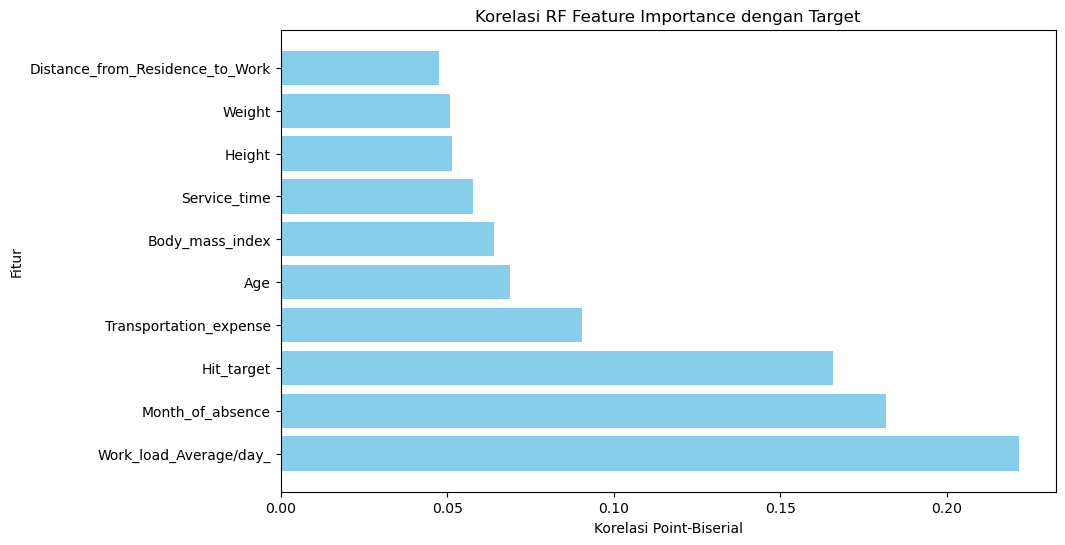

In [62]:
#plot bar hasil perhitungan korelasi
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Korelasi Point-Biserial')
plt.ylabel('Fitur')
plt.title('Korelasi RF Feature Importance dengan Target')
plt.show()

In [63]:
#menggunakan metode pointbiserialr untuk feature selection
correlations = {}
for column in num_col:
    correlation, p_value = pointbiserialr(df_fe[column], df_fe['Absenteeism_cat'])
    correlations[column] = correlation

correlation_bis = pd.DataFrame(list(correlations.items()), columns=['Feature', 'Correlation'])
print(correlation_bis)

                           Feature  Correlation
0                 Month_of_absence     0.065559
1           Transportation_expense     0.228209
2  Distance_from_Residence_to_Work    -0.011660
3                     Service_time    -0.064851
4                              Age    -0.026533
5           Work_load_Average/day_     0.047067
6                       Hit_target    -0.026516
7                           Weight     0.009749
8                           Height     0.030721
9                  Body_mass_index    -0.017395


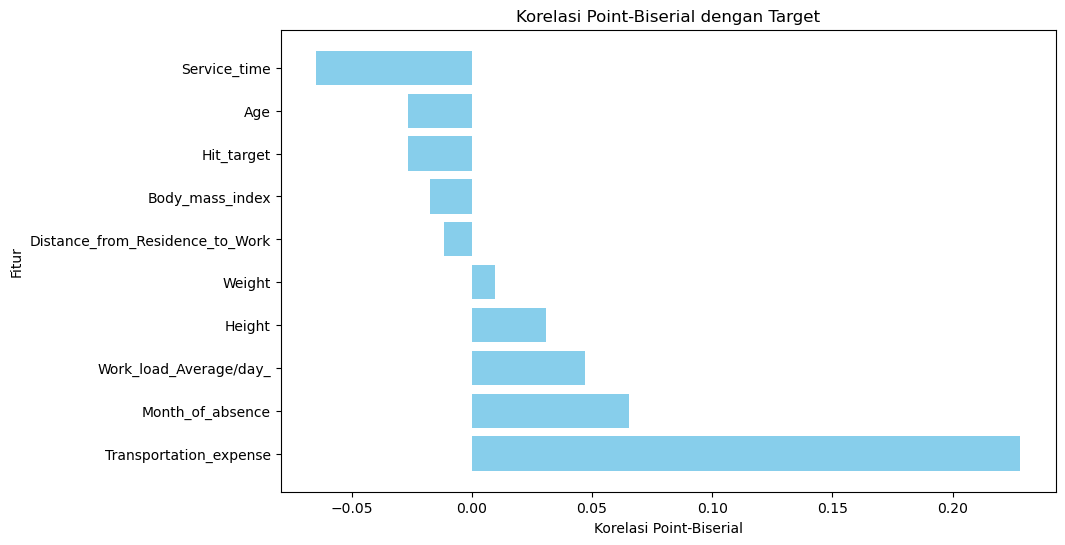

In [64]:
#plot bar hasil perhitungan korelasi
correlation_bis = correlation_bis.sort_values(by='Correlation', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(correlation_bis['Feature'], correlation_bis['Correlation'], color='skyblue')
plt.xlabel('Korelasi Point-Biserial')
plt.ylabel('Fitur')
plt.title('Korelasi Point-Biserial dengan Target')
plt.show()

In [65]:
#menggunakan metode ttest_ind untuk feature selection
group0 = df_fe[df_fe['Absenteeism_cat'] == 0]
group1 = df_fe[df_fe['Absenteeism_cat'] == 1]

p_values = {}
for col in num_col:
    t_statistic, p_value = ttest_ind(group0[col], group1[col])
    p_values[col] = p_value

p_value_df = pd.DataFrame(list(p_values.items()), columns=['Feature', 'p_value'])
print(p_value_df)

                           Feature       p_value
0                 Month_of_absence  7.669645e-02
1           Transportation_expense  4.437836e-10
2  Distance_from_Residence_to_Work  7.531449e-01
3                     Service_time  7.994337e-02
4                              Age  4.741285e-01
5           Work_load_Average/day_  2.040129e-01
6                       Hit_target  4.744103e-01
7                           Weight  7.925761e-01
8                           Height  4.072112e-01
9                  Body_mass_index  6.389179e-01


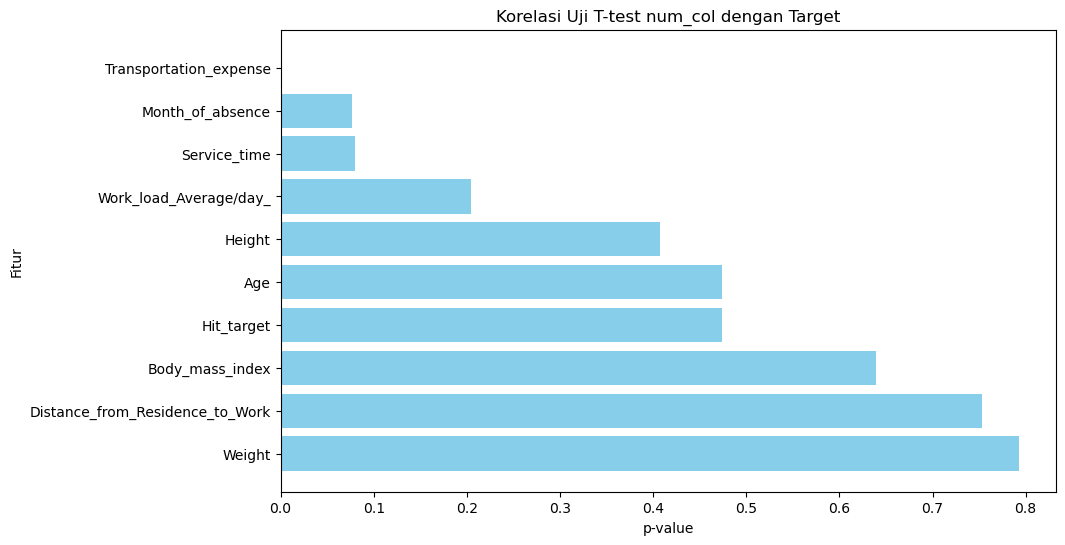

In [66]:
#plot bar hasil perhitungan korelasi
p_value_df = p_value_df.sort_values(by='p_value', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(p_value_df['Feature'], p_value_df['p_value'], color='skyblue')
plt.xlabel('p-value')
plt.ylabel('Fitur')
plt.title('Korelasi Uji T-test num_col dengan Target')
plt.show()

In [67]:
#menggunakan fungsi selectKbest untuk melakukan feature selection dengan fungsi f_classif
k = 'all'
selector = SelectKBest(score_func=f_classif, k=k)

X_baru = selector.fit_transform(X, y)

index = selector.get_support(indices=True)
feature_scores = selector.scores_

selected_features = df_fe[num_col].columns[index].tolist()

print("Selected features:", selected_features)
print("Feature scores:", feature_scores)

Selected features: ['Month_of_absence', 'Transportation_expense', 'Distance_from_Residence_to_Work', 'Service_time', 'Age', 'Work_load_Average/day_', 'Hit_target', 'Weight', 'Height', 'Body_mass_index']
Feature scores: [ 3.14246745 39.99676034  0.09898197  3.07463286  0.51287052  1.61631175
  0.51221664  0.06920237  0.68772479  0.2203448 ]


In [68]:
classif_df = pd.DataFrame({'Selected_features': selected_features, 'Feature_scores': feature_scores})
classif_df

,Selected_features,Feature_scores
0,Month_of_absence,3.142467
1,Transportation_expense,39.996760
2,Distance_from_Residence_to_Work,0.098982
3,Service_time,3.074633
4,Age,0.512871
5,Work_load_Average/day_,1.616312
6,Hit_target,0.512217
7,Weight,0.069202
8,Height,0.687725
9,Body_mass_index,0.220345


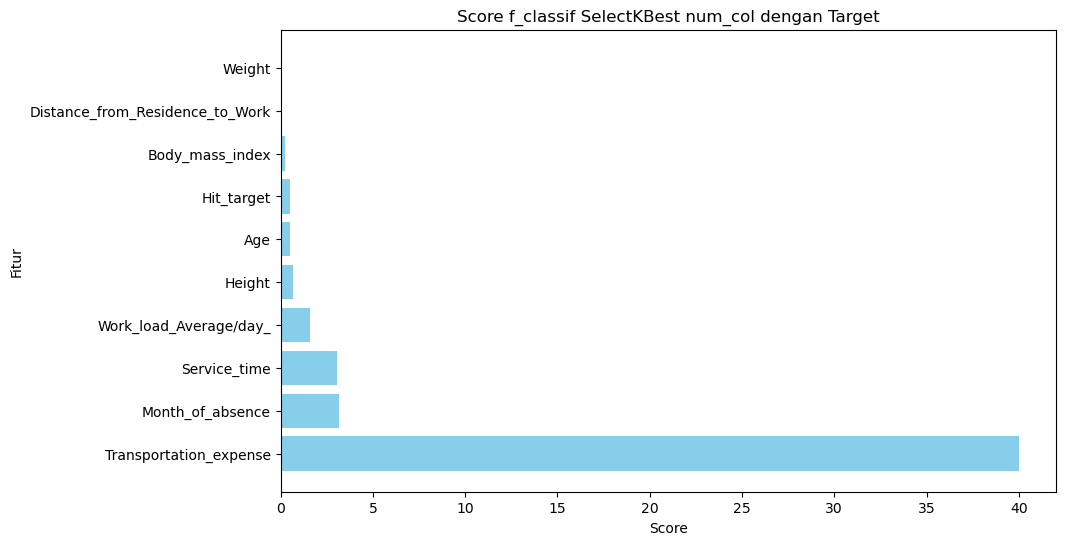

In [69]:
#plot bar hasil perhitungan korelasi
classif_df = classif_df.sort_values(by='Feature_scores', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(classif_df['Selected_features'], classif_df['Feature_scores'], color='skyblue')
plt.xlabel('Score')
plt.ylabel('Fitur')
plt.title('Score f_classif SelectKBest num_col dengan Target')
plt.show()

###Categoric

In [70]:
df_fe[cat_col]

,Reason_for_absence,Day_of_the_week,Seasons,Disciplinary_failure,Education,Son,Social_drinker,Social_smoker,Pet
0,1.0,3.0,1.0,0.0,1.0,2.0,1.0,0.0,1.0
1,0.0,3.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
2,1.0,4.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.0,5.0,1.0,0.0,1.0,2.0,1.0,1.0,0.0
4,1.0,5.0,1.0,0.0,1.0,2.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
725,0.0,3.0,1.0,0.0,1.0,2.0,1.0,0.0,1.0
726,0.0,3.0,1.0,0.0,3.0,1.0,0.0,0.0,1.0
727,0.0,3.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0
728,0.0,4.0,2.0,0.0,1.0,2.0,1.0,0.0,2.0


In [71]:
# Pisahkan fitur dan target
X = df_fe[cat_col]
y = df_fe['Absenteeism_cat']


In [72]:
#menggunakan fungsi selectKbest untuk melakukan feature selection dengan fungsi chi2
k = 'all'
selector_cat = SelectKBest(score_func=chi2, k=k)

X_baru = selector_cat.fit_transform(X, y)

index = selector_cat.get_support(indices=True)
feature_scores = selector_cat.scores_

selected_features = df_fe[cat_col].columns[index].tolist()

print("Selected features:", selected_features)
print("Feature scores:", feature_scores)

Selected features: ['Reason_for_absence', 'Day_of_the_week', 'Seasons', 'Disciplinary_failure', 'Education', 'Son', 'Social_drinker', 'Social_smoker', 'Pet']
Feature scores: [28.00328821  4.70040868  2.42911991 27.46757672  0.10946582 36.38945587
  5.33786465  0.96352286  0.12762413]


In [73]:
#membuat dataframe hasil korelasi
chi_df = pd.DataFrame({'Selected_features': selected_features, 'Feature_scores': feature_scores})
chi_df

,Selected_features,Feature_scores
0,Reason_for_absence,28.003288
1,Day_of_the_week,4.700409
2,Seasons,2.429120
3,Disciplinary_failure,27.467577
4,Education,0.109466
5,Son,36.389456
6,Social_drinker,5.337865
7,Social_smoker,0.963523
8,Pet,0.127624


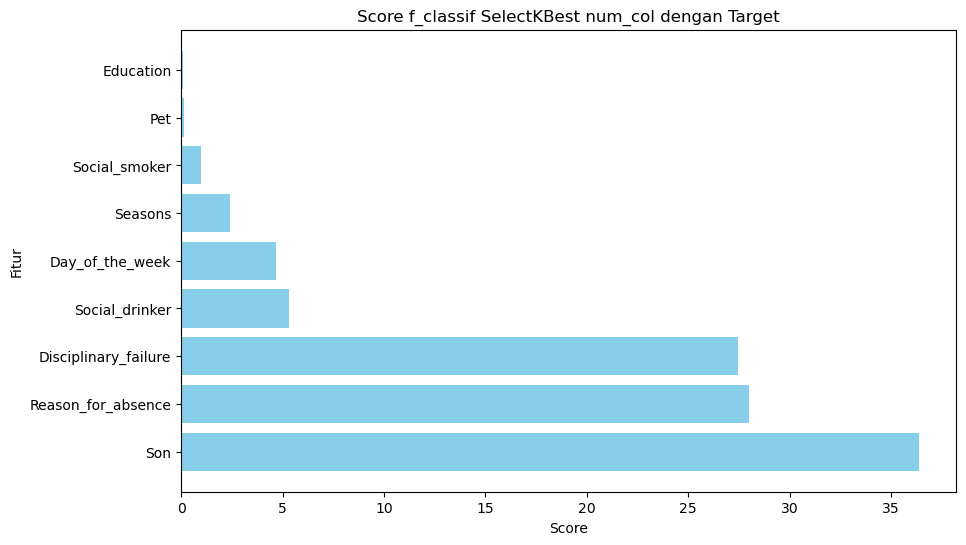

In [74]:
#plot bar hasil perhitungan korelasi
chi_df = chi_df.sort_values(by='Feature_scores', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(chi_df['Selected_features'], chi_df['Feature_scores'], color='skyblue')
plt.xlabel('Score')
plt.ylabel('Fitur')
plt.title('Score f_classif SelectKBest num_col dengan Target')
plt.show()

In [75]:
#menggunakan metode pointbiserialr untuk feature selection
correlations = {}
for column in cat_col:
    correlation, p_value = pointbiserialr(df_fe[column], df_fe['Absenteeism_cat'])
    correlations[column] = correlation

correlation_bis = pd.DataFrame(list(correlations.items()), columns=['Feature', 'Correlation'])
print(correlation_bis)

                Feature  Correlation
0    Reason_for_absence    -0.304510
1       Day_of_the_week    -0.111631
2               Seasons    -0.082549
3  Disciplinary_failure    -0.199375
4             Education    -0.021276
5                   Son     0.227488
6        Social_drinker     0.130175
7         Social_smoker     0.037726
8                   Pet     0.011253


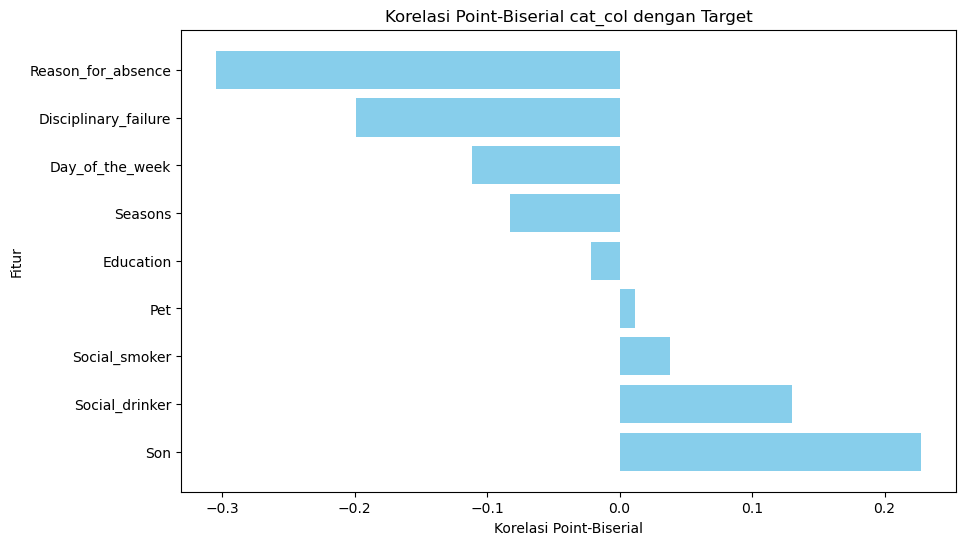

In [76]:
#plot bar hasil perhitungan korelasi
correlation_bis = correlation_bis.sort_values(by='Correlation', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(correlation_bis['Feature'], correlation_bis['Correlation'], color='skyblue')
plt.xlabel('Korelasi Point-Biserial')
plt.ylabel('Fitur')
plt.title('Korelasi Point-Biserial cat_col dengan Target')
plt.show()

In [77]:
#menggunakan metode anova untuk feature selection
anova_p_values = {}
for column in cat_col:
    groups = [df_fe.loc[df_fe[column] == value, 'Absenteeism_cat'] for value in df_fe[column].unique()]
    f_statistic, p_value = f_oneway(*groups)
    anova_p_values[column] = p_value

anova_f = pd.DataFrame(list(anova_p_values.items()), columns=['Feature', 'p_value'])
print(anova_f)

                Feature       p_value
0    Reason_for_absence  3.965212e-17
1       Day_of_the_week  2.955729e-02
2               Seasons  1.602812e-04
3  Disciplinary_failure  5.565747e-08
4             Education  2.155707e-01
5                   Son  2.835262e-09
6        Social_drinker  4.216810e-04
7         Social_smoker  3.087224e-01
8                   Pet  9.818771e-06


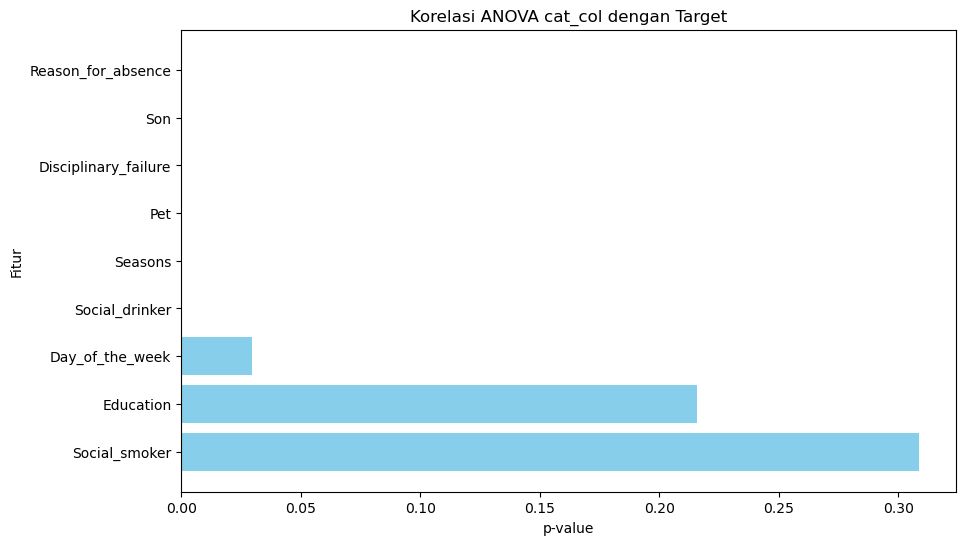

In [78]:
#plot bar hasil perhitungan korelasi
anova_f = anova_f.sort_values(by='p_value', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(anova_f['Feature'], anova_f['p_value'], color='skyblue')
plt.xlabel('p-value')
plt.ylabel('Fitur')
plt.title('Korelasi ANOVA cat_col dengan Target')
plt.show()

Berdasarkan perhitungan kuat pengaruh antar variable numerik dengan target dengan metode Feature Importance Random Forest, Point-biseral, T-test p-value, serta f_classif SelectKBest, dapat disimpulkan bahwa fitur-fitur numerik yang memiliki pengruh kuat dengan target adalah sebagai berikut:

* Transportation_expense
* Month_of_absence
* Service_time
* Work_load_Average/day

Berdasarkan perhitungan kuat pengaruh antar variable kategorik dengan target dengan metode chi2, Point-biseral, dan ANOVA dapat disimpulkan bahwa fitur-fitur kategorik yang memiliki pengaruh kuat dengan target adalah sebagai berikut:

* Reason_for_absence
* Son
* Disciplinary_failure

Secara keseluruhan, pada section feature engineering ini saya melakukan treatment fitur kategorik dan numerik yang akan dimasukkan ke dalam model, di mana sebelum dilakukan modelling, saya menentukan dahulu fitur-fitur yang akan dimasukkan ke model berdasarkan kuat hubungan fitur tersebut dengan target.

#Preprocessing

Pada tahap ini saya membuat fungsi pipeline untuk mengumpulkan alur treatment baik pada numerikal dan categorical, lalu menerapkannya juga pada data test sebelum dilakukan modelling.

In [79]:
X_train

,Reason_for_absence,Month_of_absence,Day_of_the_week,Seasons,Transportation_expense,Distance_from_Residence_to_Work,Service_time,Age,Work_load_Average/day_,Hit_target,Disciplinary_failure,Education,Son,Social_drinker,Social_smoker,Pet,Weight,Height,Body_mass_index
683,0.0,5.0,2,3,235.0,16.0,8.0,32.0,237656.0,99.0,0.0,3.0,0.0,0.0,0.0,0.0,75.0,178.0,25.0
645,1.0,3.0,4,3,369.0,17.0,12.0,31.0,222196.0,99.0,0.0,1.0,3.0,1.0,0.0,0.0,70.0,169.0,25.0
163,0.0,3.0,6,2,260.0,50.0,11.0,36.0,343253.0,95.0,0.0,1.0,3.0,1.0,0.0,0.0,65.0,168.0,23.0
360,1.0,1.0,2,2,289.0,36.0,13.0,33.0,330061.0,100.0,0.0,1.0,2.0,1.0,0.0,1.0,90.0,172.0,30.0
640,0.0,3.0,4,3,155.0,12.0,14.0,34.0,222196.0,99.0,0.0,1.0,2.0,1.0,0.0,0.0,95.0,196.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,1.0,10.0,5,4,291.0,31.0,12.0,40.0,253465.0,93.0,0.0,1.0,1.0,1.0,0.0,1.0,73.0,171.0,25.0
106,1.0,12.0,5,4,225.0,26.0,NaN,28.0,261306.0,97.0,0.0,1.0,1.0,0.0,0.0,2.0,69.0,169.0,NaN
270,0.0,9.0,4,1,289.0,36.0,13.0,33.0,294217.0,81.0,0.0,1.0,2.0,1.0,NaN,1.0,90.0,NaN,NaN
435,1.0,6.0,2,3,118.0,10.0,10.0,37.0,253957.0,95.0,0.0,1.0,0.0,0.0,0.0,0.0,83.0,172.0,28.0


In [80]:
#membuat variabel berisi fungsi pipeline untuk numerical feature iqr
num_pipeline_iqr = Pipeline([
        ('outlier', Winsorizer(capping_method='iqr', tail='both', fold=1.5, missing_values='ignore')),
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler())
    ])

num_iqr = num_pipeline_iqr.fit_transform(X_train[['Work_load_Average/day_']])
num_iqr

array([[-0.50758423],
       [-0.80071481],
       [ 1.49459623],
       [ 1.24446825],
       [-0.80071481],
       [-0.80071481],
       [ 0.20216719],
       [ 0.01119622],
       [ 0.37171271],
       [-0.64724787],
       [ 0.        ],
       [ 0.        ],
       [-0.3439165 ],
       [ 0.37171271],
       [-0.3439165 ],
       [ 0.07759618],
       [ 0.79479911],
       [-0.47159705],
       [ 0.79479911],
       [-0.0033655 ],
       [ 0.93106881],
       [-0.34797406],
       [-0.50758423],
       [-0.80071481],
       [-0.27738382],
       [-0.47434633],
       [-0.50758423],
       [ 0.72350733],
       [-1.10937411],
       [-0.43515481],
       [-0.43515481],
       [-0.20783641],
       [ 1.49459623],
       [ 0.07759618],
       [-0.80071481],
       [-0.20783641],
       [-0.47159705],
       [-0.52705675],
       [ 1.49459623],
       [ 0.38729831],
       [-0.64724787],
       [ 1.49459623],
       [-0.05063423],
       [-0.0033655 ],
       [ 0.02253465],
       [-0

In [81]:
#membuat variabel berisi fungsi pipeline untuk numerical feature gaussian
num_pipeline_gauss = Pipeline([
        ('outlier', Winsorizer(capping_method='gaussian', tail='both', fold=3, missing_values='ignore')),
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', MinMaxScaler())
    ])

num_gauss = num_pipeline_gauss.fit_transform(X_train[['Month_of_absence', 'Service_time', 'Transportation_expense']])
num_gauss

array([[0.41666667, 0.28032681, 0.43333333],
       [0.25      , 0.44051355, 0.92962963],
       [0.25      , 0.40046687, 0.52592593],
       ...,
       [0.75      , 0.48056024, 0.63333333],
       [0.5       , 0.36042018, 0.        ],
       [1.        , 0.32037349, 0.3962963 ]])

In [82]:
#membuat variabel berisi fungsi pipeline untuk categorical feature
cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),

    ])

cat_tr = cat_pipeline.fit_transform(X_train[['Reason_for_absence', 'Son', 'Disciplinary_failure']])
cat_tr

array([[0., 0., 0.],
       [1., 3., 0.],
       [0., 3., 0.],
       ...,
       [0., 2., 0.],
       [1., 0., 0.],
       [1., 1., 0.]])

In [83]:
#membuat variabel berisi fungsi pipeline untuk menyimpan seluruh proses kategorikal dan numerikal dan menggunakannya untuk fit_transform ke X_train
full_pipeline = ColumnTransformer([
        ("num_gauss", num_pipeline_gauss, ['Month_of_absence', 'Service_time', 'Transportation_expense']),
        ("num_iqr", num_pipeline_iqr, ['Work_load_Average/day_']),
        ("cat", cat_pipeline, ['Reason_for_absence', 'Son', 'Disciplinary_failure'])
    ])

X_train_pro = full_pipeline.fit_transform(X_train)
X_train_pro

array([[0.41666667, 0.28032681, 0.43333333, ..., 0.        , 0.        ,
        0.        ],
       [0.25      , 0.44051355, 0.92962963, ..., 1.        , 3.        ,
        0.        ],
       [0.25      , 0.40046687, 0.52592593, ..., 0.        , 3.        ,
        0.        ],
       ...,
       [0.75      , 0.48056024, 0.63333333, ..., 0.        , 2.        ,
        0.        ],
       [0.5       , 0.36042018, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [1.        , 0.32037349, 0.3962963 , ..., 1.        , 1.        ,
        0.        ]])

In [84]:
full_pipeline

ColumnTransformer(transformers=[('num_gauss',
                                 Pipeline(steps=[('outlier',
                                                  Winsorizer(missing_values='ignore',
                                                             tail='both')),
                                                 ('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', MinMaxScaler())]),
                                 ['Month_of_absence', 'Service_time',
                                  'Transportation_expense']),
                                ('num_iqr',
                                 Pipeline(steps=[('outlier',
                                                  Winsorizer(capping_method='iqr',
                                                             fold=1.5,
                                                             missing_values='ignore',
                                                             tail='both')),
                                                 ('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', RobustScaler())]),
                                 ['Work_load_Average/day_']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['Reason_for_absence', 'Son',
                                  'Disciplinary_failure'])])

In [85]:
#melihat shape dataframe
X_train_pro.shape

(511, 7)

In [86]:
#menggunakan fungsi full_pipeline untuk X_test
X_test_pro = full_pipeline.transform(X_test)

In [87]:
#melihat shape dataframe
X_test_pro.shape

(219, 7)

Pada tahap ini, saya melakukan preproses berupa pembuatan pipeline yang berisi masing-masing proses treatment baik untuk numerikal feature, dan  dan memasukkanya ke dalam full pipeline berupa keseluruhan treatment pada fitur yang terpilih, lalu menggunakan full pipeline untuk dataset test. Sehingga akhir dari proses ini menghasilkan variabel dataframe X_train_pro yang merupakan hasil fit_transform dengan full_pipeline terhadap dataset X_train, dan X_test_pro yang merupakan hasil transform dengan full_pipeline terhadap dataset X_test

#Model Definition

Pada kasus ini saya akan membandingkan 4 model, yaitu:

* Logistic Regression
* Support Vector Classifier
* RandomForest Classifier
* XGBoost Classifier

In [88]:
#menyimpan model awal dengan parameter awal ke dalam variabel masing-masing model
logreg = LogisticRegression(random_state=0)
svc = SVC(random_state=0)
rfc = RandomForestClassifier(random_state=0)
xgbc = XGBClassifier(random_state=0)

In [89]:
#mendapatkan parameter dari model
params_log = logreg.get_params()
params_svc = svc.get_params()
params_rfc = rfc.get_params()
params_xgbc = xgbc.get_params()

#menampilkan parameter
print(f'logreg default parameter: {params_log} \n')
print(f'svc default parameter: {params_svc} \n')
print(f'rfc default parameter: {params_rfc} \n')
print(f'xgbc default parameter: {params_xgbc} \n')


logreg default parameter: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 0, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False} 

svc default parameter: {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 0, 'shrinking': True, 'tol': 0.001, 'verbose': False} 

rfc default parameter: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'war

Pada model definition ini, model awal saya menggunakan hyperparameter default yang ditetapkan scikit learn.


#Model Training

Pada model training ini, saya ingin mencari model yang terbaik berdasarkan objektif saya, yaitu ingin mencapai model yang memiliki tingkat akurasi yang baik dengan meminimalisir setiap false positive dan false negative dari hasil prediksi model. Sehingga pada section ini, saya ingin melakukan scoring terhadap setiap model yang saya ingin uji coba pada kasus ini dengan scoring = accuracy pada saat tahap cross validation serta hyperparameter tuning

In [90]:
#membuat fungsi untuk melakukan evaluasi model
def evaluate(model):
    y_train_pred = model.predict(X_train_pro)
    y_test_pred = model.predict(X_test_pro)


    print("HASIL TRAINING: \n===============================")
    clf_report = (classification_report(y_train, y_train_pred))
    print(f"CLASSIFICATION REPORT:\n{clf_report}")
    print(f"CONFUSION MATRIX :\n")
    sns.set_style("whitegrid", {'axes.grid' : False})
    cm = confusion_matrix(y_train, y_train_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    print("HASIL TESTING: \n===============================")
    clf_report = (classification_report(y_test, y_test_pred))
    print(f"CLASSIFICATION REPORT:\n{clf_report}")
    print(f"CONFUSION MATRIX :\n")
    sns.set_style("whitegrid", {'axes.grid' : False})
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

##Logistic Regression

In [91]:
#melakukan training terhadap model logistic regression
logreg.fit(X_train_pro, y_train)

LogisticRegression(random_state=0)

HASIL TRAINING: 
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76       282
           1       0.71      0.68      0.69       229

    accuracy                           0.73       511
   macro avg       0.73      0.72      0.73       511
weighted avg       0.73      0.73      0.73       511

CONFUSION MATRIX :



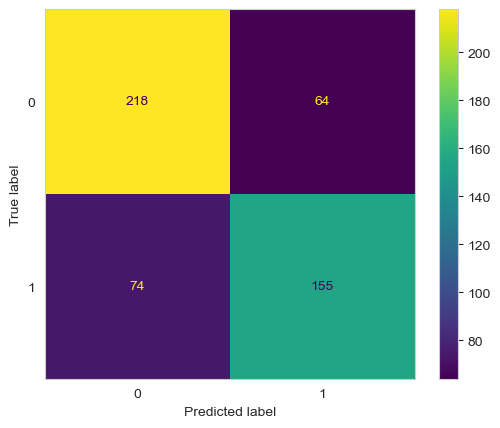

HASIL TESTING: 
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       125
           1       0.72      0.72      0.72        94

    accuracy                           0.76       219
   macro avg       0.76      0.76      0.76       219
weighted avg       0.76      0.76      0.76       219

CONFUSION MATRIX :



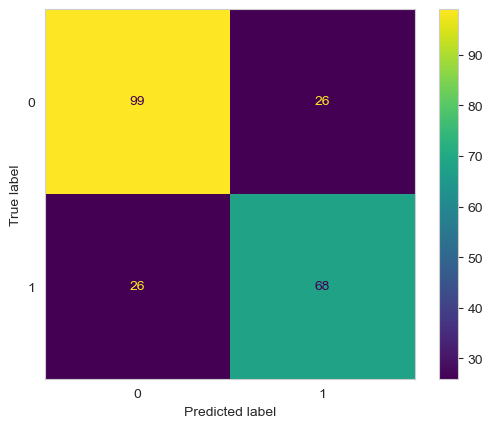

In [92]:
#memanggil fungsi evaluasi model
evaluate(logreg)

In [93]:
#melakukan cross-validation terhadap model logistic regression
logreg_pipe = Pipeline([
    ('fe', full_pipeline),
    ('model', LogisticRegression(random_state=0))
])

scores = cross_val_score(logreg_pipe, X_train, y_train, scoring='accuracy', cv=10)
print(scores)
print(scores.mean())

[0.73076923 0.78431373 0.70588235 0.74509804 0.7254902  0.76470588
 0.68627451 0.7254902  0.66666667 0.70588235]
0.7240573152337859


Best paramters: {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
HASIL TRAINING: 
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.76      0.77      0.76       282
           1       0.71      0.70      0.70       229

    accuracy                           0.74       511
   macro avg       0.73      0.73      0.73       511
weighted avg       0.74      0.74      0.74       511

CONFUSION MATRIX :



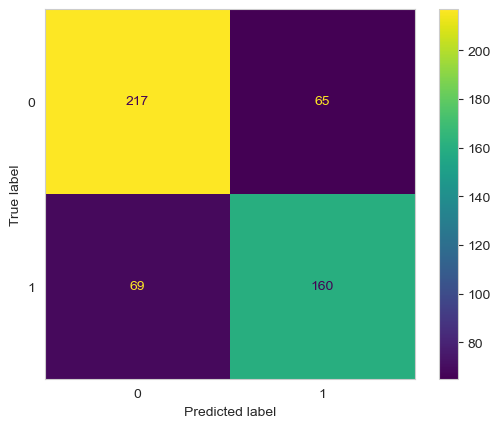

HASIL TESTING: 
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.79      0.78      0.79       125
           1       0.72      0.72      0.72        94

    accuracy                           0.76       219
   macro avg       0.75      0.75      0.75       219
weighted avg       0.76      0.76      0.76       219

CONFUSION MATRIX :



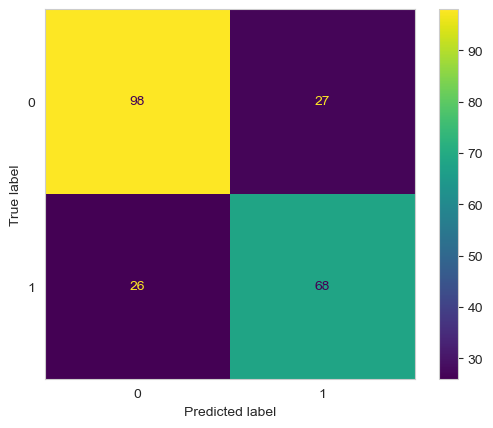

In [94]:
#melakukan hyperparameter tuning terhadap model logistic regression
params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'lbfgs', 'sag', 'newton-cg'],
    'max_iter': [100, 200, 300]
}

logreg = LogisticRegression(random_state=0)

grid_logreg = GridSearchCV(logreg, params, cv=10,
                           scoring='accuracy',
                           return_train_score=True)
grid_logreg.fit(X_train_pro, y_train)
best_params_log = grid_logreg.best_params_
print(f"Best paramters: {best_params_log}")

hyper_logreg = LogisticRegression(**best_params_log)
hyper_logreg.fit(X_train_pro, y_train)

evaluate(hyper_logreg)

##SVC

In [95]:
#melakukan training terhadap model svc
svc.fit(X_train_pro, y_train)

SVC(random_state=0)

HASIL TRAINING: 
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.74      0.77      0.76       282
           1       0.71      0.67      0.69       229

    accuracy                           0.73       511
   macro avg       0.72      0.72      0.72       511
weighted avg       0.73      0.73      0.73       511

CONFUSION MATRIX :



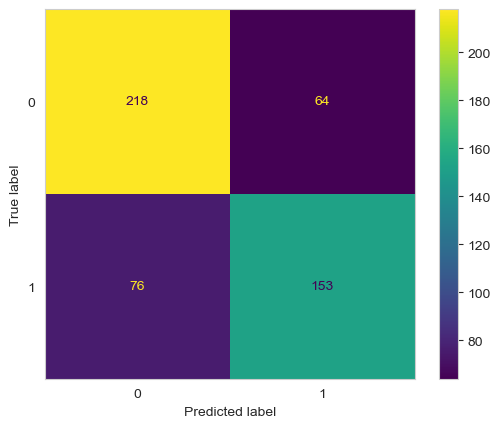

HASIL TESTING: 
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.76      0.80      0.78       125
           1       0.72      0.67      0.69        94

    accuracy                           0.74       219
   macro avg       0.74      0.74      0.74       219
weighted avg       0.74      0.74      0.74       219

CONFUSION MATRIX :



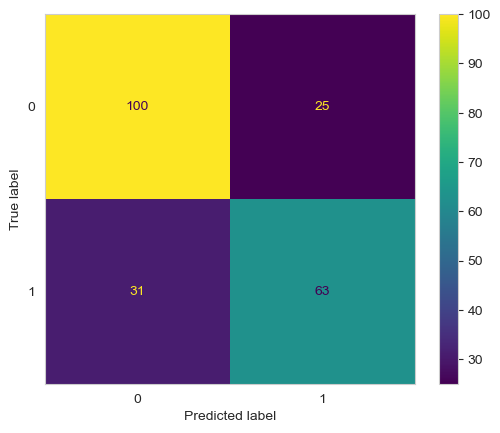

In [96]:
#memanggil fungsi evaluasi model
evaluate(svc)

In [97]:
#melakukan cross-validation terhadap model svc
svc_pipe = Pipeline([
    ('fe', full_pipeline),
    ('model', SVC(random_state=0))
])

scores = cross_val_score(svc_pipe, X_train, y_train, scoring='accuracy', cv=10)
print(scores)
print(scores.mean())

[0.73076923 0.78431373 0.64705882 0.68627451 0.70588235 0.78431373
 0.68627451 0.70588235 0.64705882 0.66666667]
0.704449472096531


Best paramters: {'C': 2.0, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}
HASIL TRAINING: 
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       282
           1       0.70      0.65      0.67       229

    accuracy                           0.72       511
   macro avg       0.71      0.71      0.71       511
weighted avg       0.72      0.72      0.71       511

CONFUSION MATRIX :



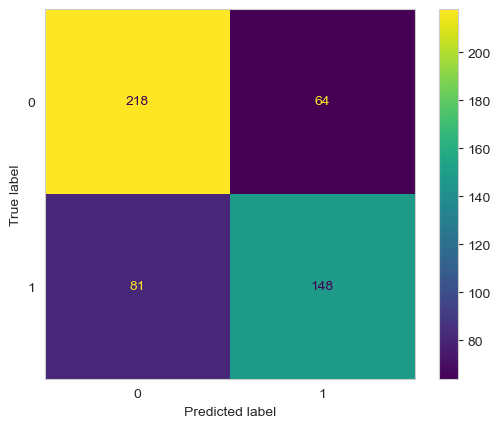

HASIL TESTING: 
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.77      0.81      0.79       125
           1       0.72      0.67      0.70        94

    accuracy                           0.75       219
   macro avg       0.74      0.74      0.74       219
weighted avg       0.75      0.75      0.75       219

CONFUSION MATRIX :



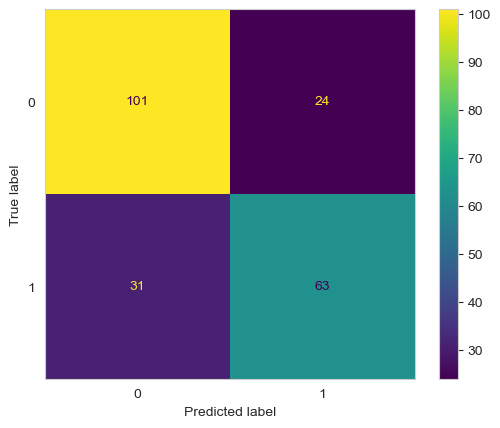

In [98]:
#melakukan hyperparameter tuning terhadap model svc
params = [
    {'C': [1.0, 2.0, 4.0, 6.0],
     'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
     'degree': [2, 3],
     'gamma': ['scale', 'auto']}
  ]


svc = SVC(random_state=0)

grid_svc = GridSearchCV(svc, params, cv=10,
                        scoring='accuracy',
                        return_train_score=True)
grid_svc.fit(X_train_pro, y_train)
best_params_svc = grid_svc.best_params_
print(f"Best paramters: {best_params_svc}")

hyper_svc = SVC(**best_params_svc)
hyper_svc.fit(X_train_pro, y_train)

evaluate(hyper_svc)

##Random Forest Classifier

In [99]:
#melakukan training terhadap model random forest classifier
rfc.fit(X_train_pro, y_train)

RandomForestClassifier(random_state=0)

HASIL TRAINING: 
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       282
           1       0.94      0.93      0.93       229

    accuracy                           0.94       511
   macro avg       0.94      0.94      0.94       511
weighted avg       0.94      0.94      0.94       511

CONFUSION MATRIX :



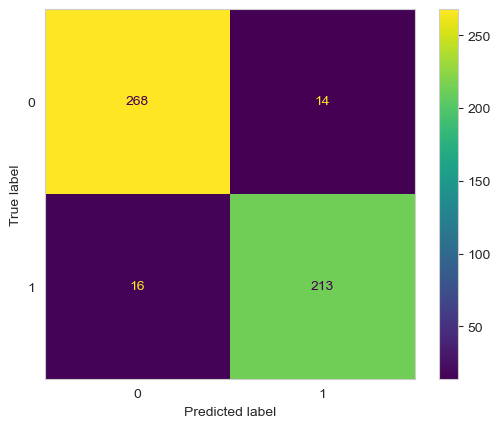

HASIL TESTING: 
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.77      0.74      0.76       125
           1       0.67      0.70      0.69        94

    accuracy                           0.73       219
   macro avg       0.72      0.72      0.72       219
weighted avg       0.73      0.73      0.73       219

CONFUSION MATRIX :



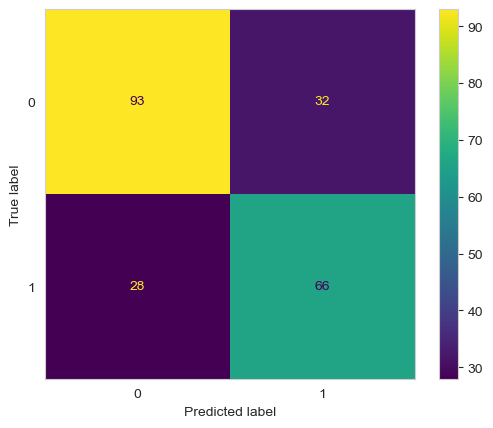

In [100]:
#memanggil fungsi evaluasi model
evaluate(rfc)

Best paramters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 2, 'n_estimators': 40}
HASIL TRAINING: 
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       282
           1       0.93      0.92      0.92       229

    accuracy                           0.93       511
   macro avg       0.93      0.93      0.93       511
weighted avg       0.93      0.93      0.93       511

CONFUSION MATRIX :



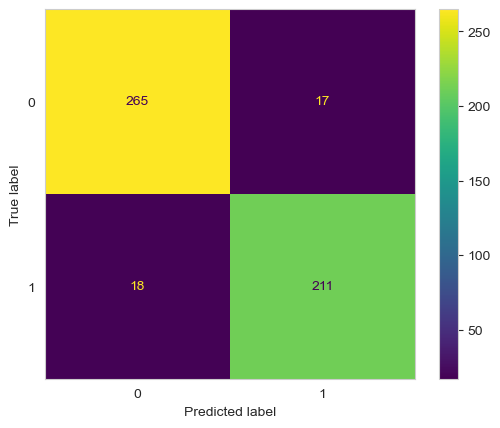

HASIL TESTING: 
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.78      0.74      0.76       125
           1       0.68      0.71      0.69        94

    accuracy                           0.73       219
   macro avg       0.73      0.73      0.73       219
weighted avg       0.73      0.73      0.73       219

CONFUSION MATRIX :



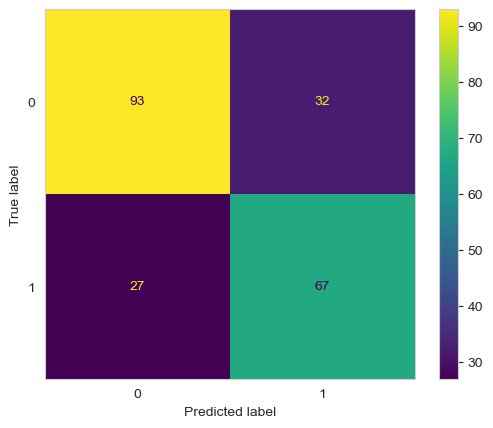

In [101]:
#melakukan hyperparameter tuning terhadap model random forest classifier
params = [
    {'n_estimators': [10, 20, 40, 60],
     'max_features': [2, 3, 5, 1],
     'max_depth': [5, 10, None],
     'criterion': ['gini', 'entropy']},
  ]



rfc = RandomForestClassifier(random_state=0)

grid_rfc = GridSearchCV(rfc, params, cv=10,
                        scoring='accuracy',
                        return_train_score=True)
grid_rfc.fit(X_train_pro, y_train)
best_params_rfc = grid_rfc.best_params_
print(f"Best paramters: {best_params_rfc}")

hyper_rfc = RandomForestClassifier(**best_params_rfc)
hyper_rfc.fit(X_train_pro, y_train)

evaluate(hyper_rfc)

##XGBoost Classifier

In [102]:
#melakukan training terhadap model XGBoost Classifier
xgbc.fit(X_train_pro, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

HASIL TRAINING: 
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       282
           1       0.93      0.94      0.93       229

    accuracy                           0.94       511
   macro avg       0.94      0.94      0.94       511
weighted avg       0.94      0.94      0.94       511

CONFUSION MATRIX :



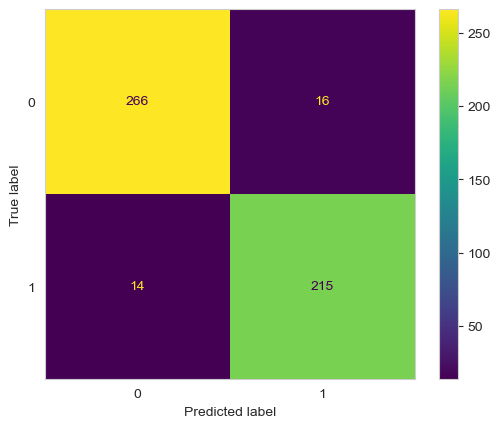

HASIL TESTING: 
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.76      0.75      0.76       125
           1       0.68      0.69      0.68        94

    accuracy                           0.73       219
   macro avg       0.72      0.72      0.72       219
weighted avg       0.73      0.73      0.73       219

CONFUSION MATRIX :



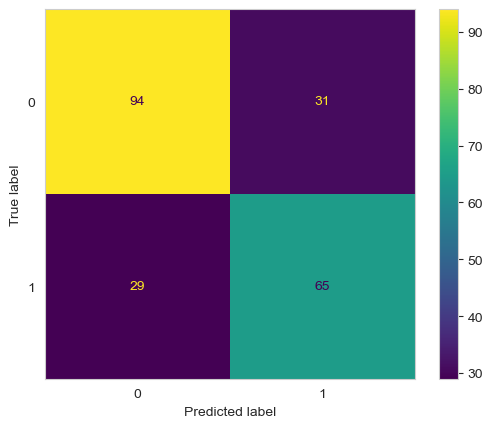

In [103]:
#memanggil fungsi evaluasi model
evaluate(xgbc)

Best paramters: {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
HASIL TRAINING: 
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89       282
           1       0.86      0.89      0.87       229

    accuracy                           0.88       511
   macro avg       0.88      0.88      0.88       511
weighted avg       0.88      0.88      0.88       511

CONFUSION MATRIX :



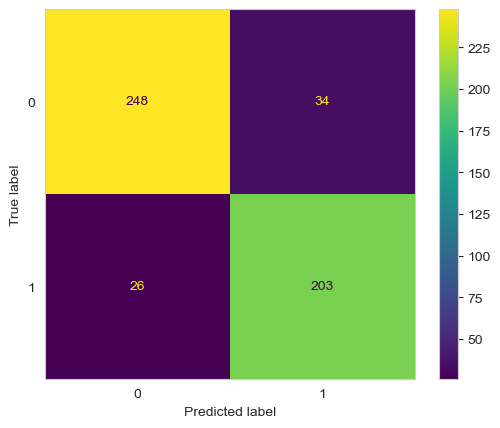

HASIL TESTING: 
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.76      0.79      0.77       125
           1       0.70      0.66      0.68        94

    accuracy                           0.74       219
   macro avg       0.73      0.73      0.73       219
weighted avg       0.73      0.74      0.73       219

CONFUSION MATRIX :



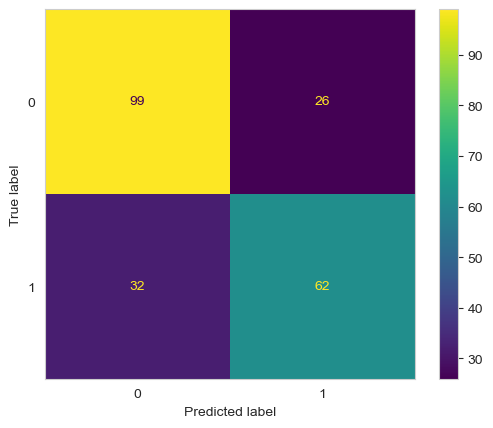

In [104]:
#melakukan hyperparameter tuning terhadap model XGBoost Classifier
params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'gamma': [0, 0.2],
}


xgbc = XGBClassifier(random_state=0)

grid_xgbc = GridSearchCV(xgbc, params, cv=10,
                        scoring='accuracy',
                        return_train_score=True)
grid_xgbc.fit(X_train_pro, y_train)
best_params_xgbc = grid_xgbc.best_params_
print(f"Best paramters: {best_params_xgbc}")

hyper_xgbc = XGBClassifier(**best_params_xgbc)
hyper_xgbc.fit(X_train_pro, y_train)

evaluate(hyper_xgbc)

##Hyperparameter Tuned Model Comparation

<Axes: >

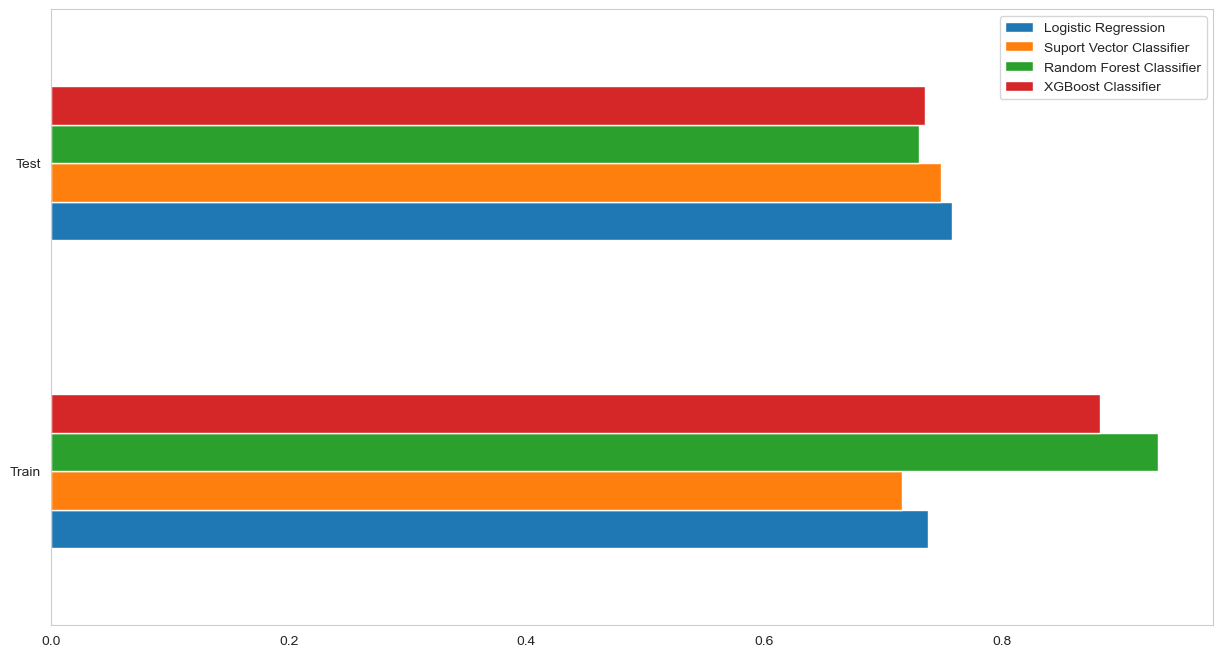

In [105]:
#membuat dataframe dan plot dari setiap accuracy score model di train dan test
acc_dict = {
    'Logistic Regression': {
        'Train': accuracy_score(y_train, hyper_logreg.predict(X_train_pro)),
        'Test': accuracy_score(y_test, hyper_logreg.predict(X_test_pro)),
    },
    'Suport Vector Classifier': {
        'Train': accuracy_score(y_train, hyper_svc.predict(X_train_pro)),
        'Test': accuracy_score(y_test, hyper_svc.predict(X_test_pro)),
    },
    'Random Forest Classifier': {
        'Train': accuracy_score(y_train, hyper_rfc.predict(X_train_pro)),
        'Test': accuracy_score(y_test, hyper_rfc.predict(X_test_pro)),
    },
    'XGBoost Classifier': {
        'Train': accuracy_score(y_train, hyper_xgbc.predict(X_train_pro)),
        'Test': accuracy_score(y_test, hyper_xgbc.predict(X_test_pro)),
    }
}

acc_df = pd.DataFrame(acc_dict)

acc_df.plot(kind='barh', figsize=(15, 8))

<Axes: >

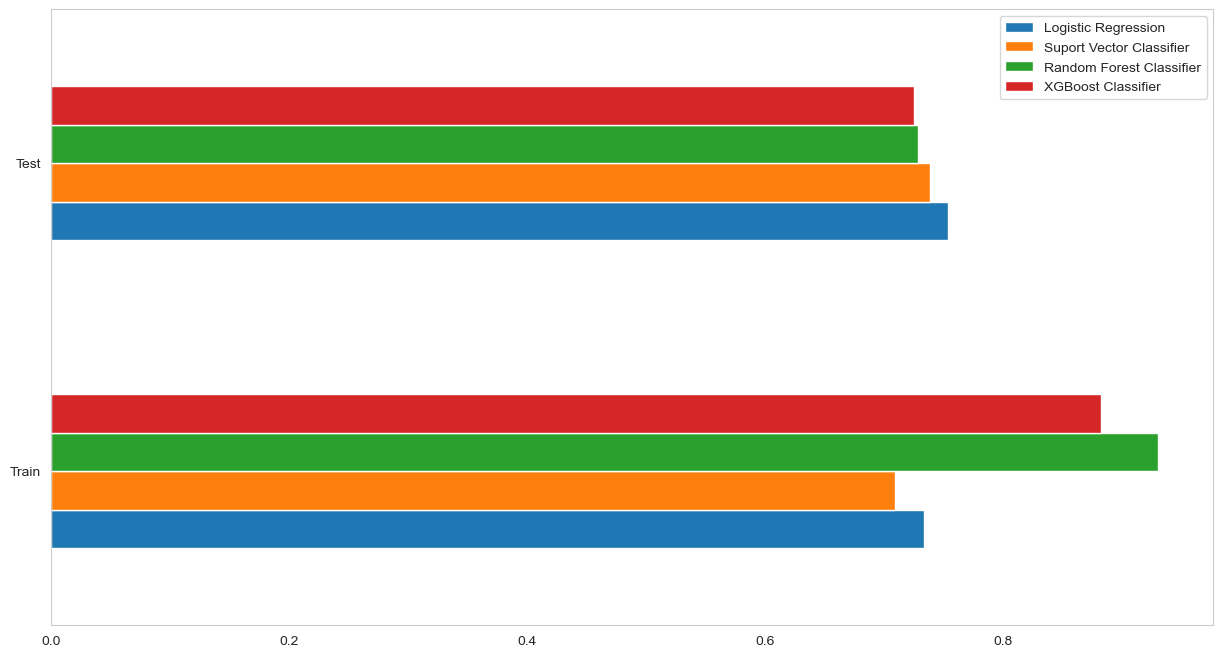

In [106]:
#membuat dataframe dan plot dari setiap roc-auc score model di train dan test
rocauc_dict = {
    'Logistic Regression': {
        'Train': roc_auc_score(y_train, hyper_logreg.predict(X_train_pro)),
        'Test': roc_auc_score(y_test, hyper_logreg.predict(X_test_pro)),
    },
    'Suport Vector Classifier': {
        'Train': roc_auc_score(y_train, hyper_svc.predict(X_train_pro)),
        'Test': roc_auc_score(y_test, hyper_svc.predict(X_test_pro)),
    },
    'Random Forest Classifier': {
        'Train': roc_auc_score(y_train, hyper_rfc.predict(X_train_pro)),
        'Test': roc_auc_score(y_test, hyper_rfc.predict(X_test_pro)),
    },
    'XGBoost Classifier': {
        'Train': roc_auc_score(y_train, hyper_xgbc.predict(X_train_pro)),
        'Test': roc_auc_score(y_test, hyper_xgbc.predict(X_test_pro)),
    }
}

rocauc_df = pd.DataFrame(rocauc_dict)

rocauc_df.plot(kind='barh', figsize=(15, 8))

#Model Evaluation



---


Mengacu pada hasil training model sebelumnya, saya memperoleh clasification report, yang memberikan nilai precision, recall, f1-score, dan accuracy, dan confusion matrix yang memuat informasi mengenai berapa nilai true positive, true negative, false positive, dan false negative. Clasification report dan confusion matrix ini akan menjadi alat saya untuk mengevaluasi model-model yang saya uji pada penelitian ini. Berikut adalah penjelasan terkait kedua alat evaluasi tersebut:

Clasification report dan confusion matrix adalah dua alat evaluasi yang sangat penting untuk mengevaluasi performa model pada tugas klasifikasi (classification) dalam penelitian ini.

1. **Classification Report**:
Classification report menyajikan metrik evaluasi seperti precision, recall, f1-score, dan support untuk setiap kelas pada data target. Berikut adalah penjelasan singkat tentang masing-masing metrik:

  - **Precision**: Precision (presisi) adalah rasio dari true positive (TP) dengan total prediksi positif (TP + false positive, FP). Metrik ini mengukur seberapa akurat model dalam mengklasifikasikan data positif. Precision tinggi menunjukkan bahwa ketika model memprediksi suatu kelas sebagai positif, kemungkinan benar juga sangat tinggi.

  - **Recall**: Recall (recall atau sensitivity) adalah rasio dari true positive (TP) dengan total data yang benar positif (TP + false negative, FN). Metrik ini mengukur seberapa baik model dalam menemukan kembali data positif yang sebenarnya. Recall tinggi menunjukkan bahwa model mampu mendeteksi sebagian besar data positif.

  - **F1-Score**: F1-score (F1-skor) adalah harmonisasi dari precision dan recall. Metrik ini memberikan keseimbangan antara precision dan recall, sehingga berguna saat terjadi ketidakseimbangan kelas. F1-score tinggi menunjukkan bahwa model memiliki keseimbangan yang baik antara kemampuan mengklasifikasikan data positif secara akurat dan menemukan kembali data positif yang sebenarnya.

2. **Confusion Matrix**:
Confusion matrix adalah tabel yang menyajikan jumlah prediksi yang benar dan yang salah dari model klasifikasi pada setiap kelas target. Sebelum menggunakannya terlebih dahulu harus didefinisikan nilai apa yang positive, di mana pada kasus ini saya mendefinisikan **nilai 1 (absent > 3 jam) sebagai nilai positive**. Berikut adalah penjelasan mengenai isi empat nilai dari tabel ini:

  - **True Positive (TP)**: Jumlah **nilai 1** yang diprediksi benar oleh model.
  - **True Negative (TN)**: Jumlah **nilai 0** yang diprediksi benar oleh model.
  - **False Positive (FP)**: Jumlah **nilai 0**  yang salah diprediksi sebagai **nilai 1** oleh model.
  - **False Negative (FN)**: Jumlah **nilai 1** yang salah diprediksi sebagai **nilai 0** oleh model.

Dari confusion matrix ini juga saya dapat menghitung metrik evaluasi lain seperti precision dan recall yang telah dijelaskan sebelumnya.



---


---



Untuk melakukan evaluasi model ini, saya menggunakan hasil dari model yang sudah dilakukan **hyperparameter tuning**, di mana saya fokus pada nilai **acccuracy**  model, yang merupakan penilaian mengenai seberapa sedikit SEMUA nilai FALSE yang dihasilkan oleh model. Berikut adalah hasil evaluasi untuk setiap model saya:

Logistic Regression (Parameter {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'})
* Nilai accuracy 0.74 di training, dan 0.76 di test (BEST FIT)
* Pada dataset test, confusion matrix memperlihatkan model berhasil memprediksi 68 true positive, 26 false positive, 99 true negative, dan 26 false negative

SVC (Parameter {'C': 2.0, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly'})
* Nilai accuracy 0.72 di training, dan 0.75 di test (BEST FIT)
* Pada dataset test, confusion matrix memperlihatkan model berhasil memprediksi 63 true positive, 24 false positive, 101 true negative, dan 31 false negative

Random Forest Classifier (Parameter {'criterion': 'entropy', 'max_depth': 10, 'max_features': 2, 'n_estimators': 40})
* Nilai accuracy 0.93 di training, dan 0.75 di test (OVER FIT)
* Pada dataset test, confusion matrix memperlihatkan model berhasil memprediksi 71 true positive, 32 false positive, 91 true negative, dan 23 false negative

XGBoost Classifier (Parameter {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100})
* Nilai accuracy 0.88 di training, dan 0.75 di test (OVER FIT)
* Pada dataset test, confusion matrix memperlihatkan model berhasil memprediksi 62 true positive, 22 false positive, 103 true negative, dan 32 false negative


Pada hasil evaluasi di atas, ditemukan bahwa model Logistic Regression dan SVC menghasilkan hasil prediksi yang BEST FIT, sedangkan Random Forest Classifier dan XGBoost Classifier menghasilkan hasil prediksi yang OVER FIT. Hal ini dapat terjadi karena Logistic Regegression dan SVC memiliki kompleksitas model yang lebih rendah dan cenderung lebih sederhana. Di mana kedua model ini memiliki batas keputusan yang lebih sederhana dan cenderung tidak "menghafal" data training dengan sekuat model berbasis pohon seperti XGBoost dan Random Forest. Ini membantu mencegah overfitting, terutama jika data training tidak terlalu kompleks atau berisi noise yang signifikan.

Berdasarkan hasil evaluasi di atas, model Logistic Regression adalah pilihan terbaik karena memberikan akurasi tertinggi pada data test dan cenderung memiliki performa yang lebih seimbang dalam memprediksi kelas positif dan negatif.

#Model Saving

Pada section ini saya melakukan penyimpanan pada pipeline all_process dengan nama file absent_pred.pkl yang berisi seluruh proses dan modelling.

In [107]:
#membuat pipeline yang berisi seluruh treatment data sampai modelling
all_process = Pipeline([
    ("preprocess", full_pipeline),
    ("classification", hyper_logreg)
])

all_process.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_gauss',
                                                  Pipeline(steps=[('outlier',
                                                                   Winsorizer(missing_values='ignore',
                                                                              tail='both')),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Month_of_absence',
                                                   'Service_time',
                                                   'Transportation_expense']),
                                                 ('num_iqr',
                                                  Pipeline(steps=[('outlier',
                                                                   Winsorizer(capping_method='iqr',
                                                                              fold=1.5,
                                                                              missing_values='ignore',
                                                                              tail='both')),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['Work_load_Average/day_']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Reason_for_absence', 'Son',
                                                   'Disciplinary_failure'])])),
                ('classification',
                 LogisticRegression(C=10, solver='liblinear'))])

In [108]:
#menyimpan model
pickle.dump(all_process, open('absent_pred.pkl', 'wb'))

In [109]:
data_inf

,Reason_for_absence,Month_of_absence,Day_of_the_week,Seasons,Transportation_expense,Distance_from_Residence_to_Work,Service_time,Age,Work_load_Average/day_,Hit_target,Disciplinary_failure,Education,Son,Social_drinker,Social_smoker,Pet,Weight,Height,Body_mass_index,Absenteeism_cat
0,0.0,5.0,5,3,225.0,15.0,15.0,41.0,237656.0,99.0,0.0,3.0,2.0,1.0,0.0,2.0,94.0,182.0,28.0,1
1,0.0,8.0,5,1,300.0,26.0,13.0,43.0,265615.0,94.0,0.0,1.0,2.0,1.0,1.0,1.0,77.0,175.0,25.0,0
2,1.0,10.0,2,4,189.0,29.0,13.0,33.0,284853.0,91.0,0.0,1.0,2.0,0.0,0.0,2.0,69.0,167.0,25.0,1
3,0.0,3.0,2,2,225.0,26.0,9.0,28.0,222196.0,99.0,0.0,1.0,1.0,0.0,0.0,2.0,69.0,169.0,24.0,1
4,1.0,5.0,4,3,179.0,51.0,18.0,38.0,246074.0,99.0,0.0,1.0,0.0,1.0,0.0,0.0,89.0,170.0,31.0,1
5,1.0,12.0,5,4,235.0,11.0,14.0,37.0,236629.0,93.0,0.0,3.0,NaN,0.0,0.0,1.0,88.0,172.0,29.0,0
6,1.0,4.0,4,3,179.0,51.0,18.0,38.0,239409.0,98.0,0.0,1.0,0.0,1.0,0.0,0.0,89.0,170.0,31.0,1
7,1.0,4.0,6,3,225.0,26.0,9.0,28.0,326452.0,96.0,0.0,1.0,1.0,0.0,0.0,2.0,69.0,169.0,24.0,0
8,1.0,4.0,3,3,155.0,12.0,14.0,34.0,246288.0,91.0,0.0,1.0,2.0,1.0,0.0,0.0,95.0,196.0,25.0,1
9,1.0,3.0,3,3,246.0,25.0,16.0,41.0,244387.0,98.0,0.0,1.0,0.0,1.0,0.0,0.0,67.0,170.0,23.0,0


#Model Inference

Pada section ini saya melakukan simulasi untuk menggunakan pipeline akhir saya untuk memprediksi data baru yang sesuai konteks data awal

In [110]:
#melihat target dari dataframe inference
data_inf['Absenteeism_cat']

0    1
1    0
2    1
3    1
4    1
5    0
6    1
7    0
8    1
9    0
Name: Absenteeism_cat, dtype: int64

In [111]:
#memprediksi hasil berdasarkan data inference
all_process.predict(data_inf)

array([1, 1, 0, 1, 0, 0, 0, 0, 0, 0])

Berdasarkan hasil prediksi data inference ini, terlihat bahwa model masih terlalu banyak mengeluarkan nilai 0 yang error.

#Kesimpulan, Kelemahan & Kelebihan, dan Pengembangan

**Kesimpulan**

Berdasarkan hasil evaluasi, model Logistic Regression adalah model terbaik dari semua model yang telah diuji untuk kasus ini. Model ini memberikan nilai akurasi yang lebih tinggi (0.76) dibandingkan dengan model lainnya seperti SVC (0.75), Random Forest Classifier (0.75), dan XGBoost Classifier (0.75). Meskipun demikian, model ini juga memiliki beberapa kelemahan yang perlu diperhatikan.

Dalam konteks hasil prediksi model dengan confusion matrix yang telah disebutkan, di mana True Positive (TP) mewakili karyawan yang absen lebih dari 3 jam (kelas positif), dan True Negative (TN) mewakili karyawan yang absen kurang dari 2 jam (kelas negatif), berikut adalah beberapa resiko dan keunggulan dari model ini jika digunakan oleh suatu perusahaan:

**Resiko/Kelemahan**:

* False Positive (FP) yang Tinggi: Model menghasilkan 26 FP, artinya ada 26 karyawan yang diprediksi akan absen lebih dari 3 jam padahal sebenarnya mereka akan absen kurang dari 3 jam. Resiko ini dapat menyebabkan perusahaan mengambil tindakan yang tidak perlu atau mengalokasikan sumber daya yang tidak efisien untuk menangani masalah yang sebenarnya tidak ada.

* False Negative (FN) yang Signifikan: Model juga menghasilkan 26 FN, yang berarti ada 26 karyawan yang sebenarnya absen lebih dari 3 jam, tetapi model gagal mendeteksinya sebagai karyawan yang absen lebih dari 3 jam. Resiko ini berarti perusahaan dapat melewatkan kesempatan untuk memberikan perhatian khusus pada karyawan, karena model tidak mengenali kondisi mereka dengan benar.

**Keunggulan**:

* Akurasi yang Relatif Tinggi: Dengan nilai akurasi sebesar 0.76 pada dataset test, model ini memiliki performa yang cukup baik dalam memprediksi secara umum. Ini berarti model memiliki tingkat ketepatan yang lumayan tinggi dalam mengklasifikasikan data positif dan negatif.

* Sensitivitas yang Baik: Model memiliki sensitivitas yang baik karena jumlah True Positive (TP) cukup tinggi (68 TP). Hal ini menunjukkan model mampu dengan baik dalam mendeteksi data positif (karyawan yang absen lebih dari 3 jam) yang sebenarnya.

**Pengembangan Model**:

Berikut adalah hal-hal yang dapat membantu untuk pengembangan model pada kasus ini
* Feature Engineering: melakukan eksplorasi lebih lanjut pada fitur-fitur yang ada untuk mengekstrak informasi tambahan yang relevan dan membantu meningkatkan performa model.
* Penanganan ketidakseimbangan: pada section Feature Engineering, kategori kelas target dimodifikasi hingga menghasilkan 2 label target yaitu 0 sejumlah 411 data sedangkan 1 sejumlah 329 data. Di mana hal ini diasumsikan sebagai balance karena memiliki perbandingan 1:1.25, namun dapat untuk dipertimbangkan menggunakan teknik oversampling atau undersampling untuk menangani masalah ini dan meningkatkan kinerja model pada kelas minoritas.
* Penyusunan ulang Hyperparameter: melakukan eksplorasi lebih lanjut pada kombinasi hyperparameter untuk mencari konfigurasi yang lebih baik untuk setiap model.

Hastie, T., Tibshirani, R., & Friedman, J. (2009). The Elements of Statistical Learning: Data Mining, Inference, and Prediction. Springer.